# Chapter 12 - Reactive flow and the emergence of melt channels

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import numpy.matlib
from scipy.optimize import fsolve
from scipy.linalg import det
from cycler import cycler

## Linearised stability analysis

### The base state

In [2]:
n = 3.0
G = 1.0
M = np.asarray([0.01, 0.1])
S = 1.0
H = 1.0
z = np.linspace(0.0, H, 1000)

F = np.power([1.0 + S*m*(1+G) for m in M], 1/n)
chi = np.asarray([(1.+G)*np.exp(m*z) - G for m in M])
cmp = -(chi + G)
phi = np.power([chij/(1.0 - S*m*cmpj) for chij, m, cmpj in zip(chi, M, cmp)], 1.0/n)
w = chi/phi
cmpl = -(1.0+G) * np.asarray([1.0 + m*z for m in M])
chil = 1.0 + np.asarray([m*(1+G)*z for m in M])
phil = np.asarray([1.0/Fj * (1.0 + m*(1.0 + G)/n*z) for Fj, m in zip(F, M)])
wl = np.asarray([Fj*(1.0 + m*(1.0+G)*(1.0-1.0/n)*z) for Fj, m in zip(F, M)])

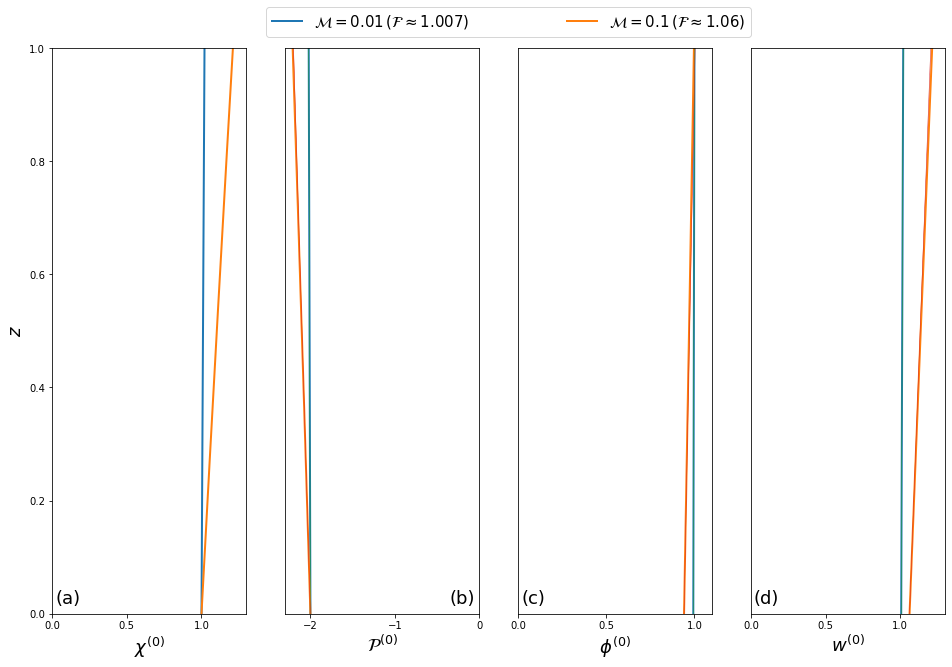

In [3]:
f, ax = plt.subplots(1, 4)
zoom = 2.0
f.set_size_inches(8.0 * zoom, 5.2 * zoom)
f.set_facecolor('w')

plt.rc('axes', prop_cycle=(cycler(color=['k', 'k', 'k', 'k']) + cycler(linestyle=['-', '--', ':', '-.'])))

lines = ax[0].plot(chi.transpose(), z, linewidth=2.0)
ax[0].set_xlabel(r'$\chi^{(0)}$', fontsize=18)
ax[0].set_xlim(0.0, 1.3)
ax[0].set_xticks((0.0, 0.5, 1.0))
ax[0].set_ylabel('$z$', fontsize=18)
ax[0].set_ylim(0.0, 1.0)
ax[0].text(0.02, 0.01, '(a)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')
plt.legend(handles=(lines[0], lines[1]), 
           labels=(r'$\mathcal{M}=0.01\,(\mathcal{F}\approx1.007)$', r'$\mathcal{M}=0.1\,(\mathcal{F}\approx1.06)$'),
           fontsize=15, bbox_to_anchor=(-2.5, 1.02, 2.5, .2),
           loc='lower right', ncol=2, mode="expand", borderaxespad=0.)

ax[1].plot(cmp.transpose(), z, linewidth=2.0)
ax[1].plot(cmpl.transpose(), z, linewidth=0.5)
ax[1].set_xlabel(r'$\mathcal{P}^{(0)}$', fontsize=18)
ax[1].set_xlim(-2.3, 0.0)
ax[1].set_xticks((-2.0, -1.0, 0.0))
ax[1].set_yticks(())
ax[1].set_ylim(0.0, 1.0)
ax[1].text(-0.35, 0.01, '(b)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[2].plot(phi.transpose(), z, linewidth=2)
ax[2].plot(phil.transpose(), z, linewidth=0.5)
ax[2].set_yticks(())
ax[2].set_xlabel(r'$\phi^{(0)}$', fontsize=18)
ax[2].set_xlim(0.0, 1.1)
ax[2].set_xticks((0.0, 0.5, 1.0))
ax[2].set_ylim(0.0, 1.0)
ax[2].text(0.02, 0.01, '(c)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[3].plot(w.transpose(), z, linewidth=2)
ax[3].plot(wl.transpose(), z, linewidth=0.5)
ax[3].set_xlabel(r'$w^{(0)}$', fontsize=18)
ax[3].set_yticks(())
ax[3].set_xlim(0.0, 1.3)
ax[3].set_ylim(0.0, 1.0)
ax[3].set_xticks((0.0, 0.5, 1.0))
ax[3].text(0.02, 0.01, '(d)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

plt.show()

### The growth rate of perturbations

In [4]:
class PAR:
    def __init__(self, F_=1.0, n_=3, S_=1.0, Da_=1000.0, Pe_=100.0, M_=0.01, G_=1,
                 bc_=2, nz_=1000, tol_=1e-5, plot_=False, step_=0.01, largeDa_=False):
        self.F = F_  # base - state parameter - force to be constant
        self.n = n_  # permeability exponent
        self.S = S_  # rigidity parameter
        self.Da = Da_  # Damkohler number
        self.Pe = Pe_  # Peclet number
        self.M = M_  # solubility gradient parameter
        self.G = G_  # decompression melting parameter
        self.bc_type = bc_  # boundary condition type -- 1) P(1)=0; 2) P'(1)=0
        self.nz = nz_  # number of points for eigenfunction
        self.tol = tol_  # tolerance
        self.plot = plot_  # plot eigenfunction
        self.step = step_  # stepsize in log10(k)--sigma space
        self.largeDa = largeDa_

        
class EIG:
    def __init__(self, p_=0.0, phi_=0.0):
        self.P = p_
        self.phi = phi_


class SA:
    def __init__(self, k_=0.0, sigma_=0.0, m_=0.0, flag_=False):
        self.k = k_
        self.sigma = sigma_
        self.m = m_
        self.eig = EIG()
        self.flag = flag_


class DC:
    def __init__(self, s_=0.0, k_=0.0, m_=0.0):
        self.s = s_
        self.k = k_
        self.m = m_

In [5]:
def zero_by_sigma(sig, k, par):
    m = np.roots(characteristic_polynomial(k, sig, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sig, par))
        residual = np.real((1.0 - 1.j) * detM)
    return residual


def zero_by_wavenumber(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sigma, par))
        residual = np.real((1 - 1j) * detM)
    return residual


def characteristic_polynomial(k, sig, par):
    K = k ** 2 / par.Da / par.Pe / par.F + 1.0
    p = np.asarray([0.0 if par.largeDa else sig / par.Da,  # cubic
                    sig * K - par.n * np.power(par.F, 1 + par.n) / par.Da / par.S,  # quadratic
                    -(par.n * np.power(par.F, 1 + par.n) * K / par.S + sig * k ** 2 / par.Da),  # linear
                    k ** 2 * (par.n * np.power(par.F, 1 - par.n) - sig * K)])  # constant
    return p.reshape(p.shape[0])

  
def boundary_condition_matrix(k, m, sig, par):
    if par.bc_type == 1:
        M = np.asarray([[1.0, mi, np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 2:
        M = np.asarray([[1.0, mi, mi * np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 3:
        q = sig * par.S / par.n
        M = np.asarray([[q * mi - 1.0, q * mi ** 2 - mi - q * k ** 2, mi * np.exp(mi)] for mi in m]).transpose()
    else:
        q = k ** 2 * par.Da / par.DaPe
        M = np.asarray([[1.0 - par.S * mi, mi ** 2 + q * mi, mi * np.exp(mi)] for mi in m]).transpose()
    return M


def form_eigenfunction(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    z = np.linspace(0.0, 1.0, par.nz)
    eig = EIG()
    if par.largeDa:
        eig.P = np.exp(np.real(m[0]) * z) * np.sin(np.imag(m[0]) * z)
        eig.P = eig.P / np.max(np.abs(eig.P))
        Q = (m[0] ** 2 - k ** 2) * eig.P
        eig.phi = np.power(par.F, -1.0 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    else:
        M = boundary_condition_matrix(k, m, sigma, par)
        subM = M[:, 1::]
        b = -M[:, 0]
        A = np.concatenate((np.asarray([1.0+0.j]), np.linalg.lstsq(subM, b, rcond=None)[0]))
        eig.P = np.sum(np.asarray([Aj * np.exp(mj * z) for Aj, mj in zip(A, m)]).transpose(), axis=1)
        Q = np.sum(np.asarray([(mj ** 2 - k ** 2) * Aj * np.exp(mj * z) 
                               for Aj, mj in zip(A, m)]).transpose(), axis=1)
        eig.phi = np.power(par.F, -1 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    return eig

In [6]:
def reactive_flow_solve_dispersion(k_guess, sigma_guess, par):
    # input parameters:
    #   k -- horizontal wavenumber (required)
    #   sigma_guess -- guess at the eigenvalue (optional)
    #   par -- parameter structure (optional)

    sa = SA()

    if type(k_guess) is not np.ndarray:
        # solving for growthrate sigma at a fixed value of wavenumber k
        solve_for_sigma = True
        sa.k = k_guess
        if sigma_guess is None:
            sigma_guess = np.logspace(-1.0, 1.0, 100)
        if type(sigma_guess) is not np.ndarray:
            sigma_guess = np.asarray([sigma_guess])
    else:
        # solving for wavenumber k at a fixed value of growthrate sigma
        solve_for_sigma = False
        sa.sigma = sigma_guess if type(sigma_guess) is not np.ndarray else sigma_guess[0]

    if par.F is None:
        par.F = np.power(1.0 + par.S * par.M * (1.0 + par.G), 1.0 / par.n)

    sigma = np.zeros_like(sigma_guess)
    k = np.zeros_like(k_guess)
    if solve_for_sigma:
        # solve eigenvalue problem to find growth rate of fastest-growing mode
        res = np.zeros_like(sigma_guess)
        exitflag = np.zeros_like(sigma_guess)
        converged = np.zeros_like(sigma_guess)
        problem_sigma = lambda s: zero_by_sigma(s, sa.k, par)
        for j in range(len(sigma_guess)):
            [sigma[j], infodict, exitflag[j], _] = fsolve(problem_sigma, sigma_guess[j], 
                                                          full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 and np.abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(sa.k, sigma[j], par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(sa.k, sigma[j], par)
                # plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))
    else:
        # solve eigenvalue problem to find wavenumber of mode
        problem_wavenumber = lambda s: zero_by_wavenumber(s, sa.sigma, par)
        res = np.zeros_like(k_guess)
        exitflag = np.zeros_like(k_guess)
        converged = np.zeros_like(k_guess)
        for j in range(len(k_guess)):
            [k[j], infodict, exitflag[j], _] = fsolve(problem_wavenumber, k_guess[j], full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 or abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(k[j], sa.sigma, par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(k[j], sa.sigma, par)
                plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))

        # [converged', exitflag', log10(abs(res'))];
    none_converged = not np.sum(converged)

    # handle failure to find solution
    if none_converged:
        print(f'FAILURE: no solution found for k={k_guess}')
        sa.sigma = np.nan
        sa.k = np.nan
        sa.m = [np.nan, np.nan, np.nan]
        sa.eig.P = np.nan
        sa.flag = False
        return sa
    elif solve_for_sigma:
        sa.sigma = np.amax(sigma[converged != 0])
    else:
        sa.k = np.amax(k[converged != 0])

    sa.m = np.roots(characteristic_polynomial(sa.k, sa.sigma, par))

    # form and check eigenfunction
    sa.eig = form_eigenfunction(sa.k, sa.sigma, par)
    gP = np.gradient(sa.eig.P)
    # if len(np.nonzero(gP < 0)) > 1 and par.bc_type is not 1:  # TODO: check
    if (gP < 0).any() and par.bc_type != 1:
        sa.flag = False
        print(f'FAILURE: non-monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')
    else:
        sa.flag = True
        print(f'SUCCESS: monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')

    if par.plot:
        plt.plot(np.linspace(0, 1, par.nz), np.real(sa.eig.P), linewidth=2)

    return sa

In [7]:
def taylor_series_extension(n, x, y, step, init_Lks):
    if n == 0:
        xguess = init_Lks[0]
        yguess = init_Lks[1]
    elif n == 1:
        xguess = x[0]-step
        yguess = y[0]
    elif n == 2:
        d = np.asarray([x[1]-x[0], y[1]-y[0]])
        d = d/np.sqrt(np.sum(d**2))
        xguess = x[-1] + d[0]*step
        yguess = y[-1] + d[1]*step
    else:
        da = np.asarray([x[-1]-x[-2], y[-1]-y[-2]])
        db = np.asarray([x[-2]-x[-3], y[-2]-y[-3]])
        D = 0.5*(np.sqrt(np.sum(da**2)) + np.sqrt(np.sum(db**2)))
        da = da/np.sqrt(np.sum(da**2))
        db = db/np.sqrt(np.sum(db**2))
        d2 = (da - db)/D
        xguess = x[-1] + da[0]*step + 0.5*d2[0]*step**2
        yguess = y[-1] + da[1]*step + 0.5*d2[1]*step**2

    if np.isinf(xguess) or np.isnan(xguess):
        xguess = x[-1]
    if np.isinf(yguess) or np.isnan(yguess):
        yguess = y[-1]

    return xguess, yguess

In [8]:
def reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks):
    n = 0  # can n be zero?
    Lk = np.full((1, ), np.inf)  # dictionaries
    s = np.full((1, ), np.inf)
    m = m = np.full((1, 2), np.inf + 0.j, dtype=np.complex) if par.largeDa \
        else np.full((1, 3), np.inf + 0.j, dtype=np.complex)

    for j in [0, 1]:
        fails = 0
        while n < 1_000_000:
            Lk_guess, s_guess = taylor_series_extension(n, Lk, s, par.step, init_Lks)
            if Lk_guess <= Lkbounds[0] or Lk_guess >= Lkbounds[1]:
                break
            if s_guess <= sbounds[0] or s_guess >= sbounds[1]:
                break

            if n == 0:
                s_guess = np.linspace(0.1, par.n, 30)
            elif fails <= 1:
                print(f'Iteration {n}: searching for solution at k={np.power(10, Lk_guess)}')
                s_guess = s_guess * np.linspace(0.99, 1.01, 16)
            elif fails == 2:
                print(f'Iteration {n}: searching for solution at sigma={s_guess}')
                Lk_guess = Lk_guess * np.linspace(0.99, 1.01, 16)
            else:
                break

            sa = reactive_flow_solve_dispersion(np.power(10., Lk_guess), s_guess, par)

            if sa.flag:
                # found lowest mode; prepare for next iteration
                if n == 0:
                    Lk[n] = np.log10(sa.k)
                    s[n] = sa.sigma
                    m[n] = sa.m
                else:
                    Lk = np.concatenate((Lk, np.asarray([np.log10(sa.k)])))
                    s = np.concatenate((s, np.asarray([sa.sigma])))
                    m = np.concatenate((m, np.asarray([sa.m])))
                n = n + 1
                fails = 0
            else:
                # found higher mode; retry
                fails = fails + 1

        if j == 0:
            s = np.flip(s)
            Lk = np.flip(Lk)
            m = np.flipud(m)

    return DC(s, np.power(10., Lk), m)

In [10]:
par = PAR()

Lkbounds = np.log10([0.1, 400.0])
sbounds = np.asarray([0.05, 4.0])
init_Lks = np.asarray([np.log10(5.0), 3.0])

DC_ref = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)
iref = np.argmax(DC_ref.s)

dpar = par
dpar.Da = 10.0
DC_a = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)
dpar.Da = 100.0
DC_b = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)

SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.596489830144003
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.5793461640905706
Iteration 2: searching for solution at k=4.8298258486684915
SUCCESS: monotonic eigenfunction for k=4.8298258486684915, sigma=2.57045525456229
Iteration 3: searching for solution at k=4.77570019745004
SUCCESS: monotonic eigenfunction for k=4.77570019745004, sigma=2.5616530658570715
Iteration 4: searching for solution at k=4.7229374259332095
SUCCESS: monotonic eigenfunction for k=4.7229374259332095, sigma=2.5528139088490143
Iteration 5: searching for solution at k=4.671485390538257
SUCCESS: monotonic eigenfunction for k=4.671485390538257, sigma=2.54393896356508
Iteration 6: searching for solution at k=4.621296646934616
SUCCESS: monotonic eigenfunction for k=4.621296646934616, sigma=2.5350297549011778
Iteration 7: searching for solution at k=4.572325718222083
SUCCESS: 

SUCCESS: monotonic eigenfunction for k=3.0379291375704978, sigma=2.046097557419773
Iteration 59: searching for solution at k=3.0190647462210927
SUCCESS: monotonic eigenfunction for k=3.0190647462210927, sigma=2.0364314656429285
Iteration 60: searching for solution at k=3.000457893037922
SUCCESS: monotonic eigenfunction for k=3.000457893037922, sigma=2.0267600962606216
Iteration 61: searching for solution at k=2.9821028283150945
SUCCESS: monotonic eigenfunction for k=2.9821028283150945, sigma=2.0170835844534043
Iteration 62: searching for solution at k=2.9639939824961408
SUCCESS: monotonic eigenfunction for k=2.9639939824961408, sigma=2.0074020604547544
Iteration 63: searching for solution at k=2.946125959445914
SUCCESS: monotonic eigenfunction for k=2.946125959445914, sigma=1.9977156497515944
Iteration 64: searching for solution at k=2.9284935300215
SUCCESS: monotonic eigenfunction for k=2.9284935300215, sigma=1.9880244732748926
Iteration 65: searching for solution at k=2.9110916259274

SUCCESS: monotonic eigenfunction for k=2.256413936552473, sigma=1.489288224474047
Iteration 116: searching for solution at k=2.246539843771272
SUCCESS: monotonic eigenfunction for k=2.246539843771272, sigma=1.4794430842493436
Iteration 117: searching for solution at k=2.2367630800625897
SUCCESS: monotonic eigenfunction for k=2.2367630800625897, sigma=1.469595846875035
Iteration 118: searching for solution at k=2.2270825745299168
SUCCESS: monotonic eigenfunction for k=2.2270825745299168, sigma=1.4597465185876184
Iteration 119: searching for solution at k=2.21749729193307
SUCCESS: monotonic eigenfunction for k=2.21749729193307, sigma=1.449895104331992
Iteration 120: searching for solution at k=2.2080062322000464
SUCCESS: monotonic eigenfunction for k=2.2080062322000464, sigma=1.4400416077527871
Iteration 121: searching for solution at k=2.198608429974093
SUCCESS: monotonic eigenfunction for k=2.198608429974093, sigma=1.4301860311836299
Iteration 122: searching for solution at k=2.1893029

SUCCESS: monotonic eigenfunction for k=1.8209875860248355, sigma=0.904256418871573
Iteration 175: searching for solution at k=1.8161494995133163
SUCCESS: monotonic eigenfunction for k=1.8161494995133163, sigma=0.8942322119977799
Iteration 176: searching for solution at k=1.811408959431238
SUCCESS: monotonic eigenfunction for k=1.811408959431238, sigma=0.8842013509494759
Iteration 177: searching for solution at k=1.8067676381968854
SUCCESS: monotonic eigenfunction for k=1.8067676381968854, sigma=0.8741634635426274
Iteration 178: searching for solution at k=1.8022273167477263
SUCCESS: monotonic eigenfunction for k=1.8022273167477263, sigma=0.8641181389042176
Iteration 179: searching for solution at k=1.7977898907047465
SUCCESS: monotonic eigenfunction for k=1.7977898907047465, sigma=0.8540649216851127
Iteration 180: searching for solution at k=1.7934573770581845
SUCCESS: monotonic eigenfunction for k=1.7934573770581845, sigma=0.8440033051194522
Iteration 181: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=1.8077962248625017, sigma=0.3684978610174378
Iteration 229: searching for solution at k=1.8168293531822182
SUCCESS: monotonic eigenfunction for k=1.8168293531822182, sigma=0.3590882669002882
Iteration 230: searching for solution at k=1.8265669797070296
SUCCESS: monotonic eigenfunction for k=1.8265669797070296, sigma=0.34970684824880616
Iteration 231: searching for solution at k=1.8370483397434019
SUCCESS: monotonic eigenfunction for k=1.8370483397434019, sigma=0.34035854602811827
Iteration 232: searching for solution at k=1.8483146513564606
SUCCESS: monotonic eigenfunction for k=1.8483146513564606, sigma=0.33104862994809753
Iteration 233: searching for solution at k=1.860409093908101
SUCCESS: monotonic eigenfunction for k=1.860409093908101, sigma=0.3217827325364915
Iteration 234: searching for solution at k=1.8733767541244355
SUCCESS: monotonic eigenfunction for k=1.8733767541244355, sigma=0.3125668783559171
Iteration 235: searching for solution a

FAILURE: no solution found for k=3.237607017421601
Iteration 269: searching for solution at k=3.237607017421601
FAILURE: no solution found for k=3.237607017421601
Iteration 269: searching for solution at sigma=0.07658126376116571
SUCCESS: monotonic eigenfunction for k=3.2394471633702038, sigma=0.07658126376116571
Iteration 270: searching for solution at k=3.310143618198963
FAILURE: no solution found for k=3.310143618198963
Iteration 270: searching for solution at k=3.310143618198963
FAILURE: no solution found for k=3.310143618198963
Iteration 270: searching for solution at sigma=0.07310054998860212
SUCCESS: monotonic eigenfunction for k=3.312024069398587, sigma=0.07310054998860212
Iteration 271: searching for solution at k=3.3847485863580538
FAILURE: no solution found for k=3.3847485863580538
Iteration 271: searching for solution at k=3.3847485863580538
FAILURE: no solution found for k=3.3847485863580538
Iteration 271: searching for solution at sigma=0.0697777081580978
SUCCESS: monoton

SUCCESS: monotonic eigenfunction for k=11.415074017957389, sigma=2.910082086905871
Iteration 321: searching for solution at k=11.665658243125462
SUCCESS: monotonic eigenfunction for k=11.665658243125462, sigma=2.913336056887695
Iteration 322: searching for solution at k=11.923027746241063
SUCCESS: monotonic eigenfunction for k=11.923027746241063, sigma=2.916456278126656
Iteration 323: searching for solution at k=12.187306941781522
SUCCESS: monotonic eigenfunction for k=12.187306941781522, sigma=2.919445020827524
Iteration 324: searching for solution at k=12.458622664553095
SUCCESS: monotonic eigenfunction for k=12.458622664553095, sigma=2.9223046691942915
Iteration 325: searching for solution at k=12.737104450944475
SUCCESS: monotonic eigenfunction for k=12.737104450944475, sigma=2.925037699981352
Iteration 326: searching for solution at k=13.022884806509095
SUCCESS: monotonic eigenfunction for k=13.022884806509095, sigma=2.9276466615917602
Iteration 327: searching for solution at k=13

SUCCESS: monotonic eigenfunction for k=41.74193322784286, sigma=2.937720251417778
Iteration 378: searching for solution at k=42.693799612093876
SUCCESS: monotonic eigenfunction for k=42.693799612093876, sigma=2.935632010475406
Iteration 379: searching for solution at k=43.6650158190177
SUCCESS: monotonic eigenfunction for k=43.6650158190177, sigma=2.9334320715106803
Iteration 380: searching for solution at k=44.655721790206634
SUCCESS: monotonic eigenfunction for k=44.655721790206634, sigma=2.9311178279220607
Iteration 381: searching for solution at k=45.66603290421845
SUCCESS: monotonic eigenfunction for k=45.66603290421845, sigma=2.9286866604415294
Iteration 382: searching for solution at k=46.69603770155946
SUCCESS: monotonic eigenfunction for k=46.69603770155946, sigma=2.926135952860536
Iteration 383: searching for solution at k=47.74579560165704
SUCCESS: monotonic eigenfunction for k=47.74579560165704, sigma=2.923463108929129
Iteration 384: searching for solution at k=48.815334642

FAILURE: non-monotonic eigenfunction for k=103.70313648096845, sigma=2.6937281397272814
Iteration 422: searching for solution at k=103.70313648096845
FAILURE: non-monotonic eigenfunction for k=103.70313648096845, sigma=2.6937281397272814
Iteration 422: searching for solution at sigma=2.6971123364865974
SUCCESS: monotonic eigenfunction for k=104.52873070353834, sigma=2.6971123364865974
Iteration 423: searching for solution at k=106.35740879670092
SUCCESS: monotonic eigenfunction for k=106.35740879670092, sigma=2.6858583716805353
Iteration 424: searching for solution at k=107.58623796751674
FAILURE: non-monotonic eigenfunction for k=107.58623796751674, sigma=2.674035446349707
Iteration 424: searching for solution at k=107.58623796751674
FAILURE: non-monotonic eigenfunction for k=107.58623796751674, sigma=2.674035446349707
Iteration 424: searching for solution at sigma=2.6770794052830618
SUCCESS: monotonic eigenfunction for k=108.3606709964764, sigma=2.6770794052830618
Iteration 425: sear

FAILURE: no solution found for k=141.81567179313137
Iteration 446: searching for solution at sigma=2.4878360211282993
SUCCESS: monotonic eigenfunction for k=141.80539383411372, sigma=2.4878360211282993
Iteration 447: searching for solution at k=143.3066827374274
FAILURE: non-monotonic eigenfunction for k=143.3066827374274, sigma=2.4622685948654177
Iteration 447: searching for solution at k=143.3066827374274
FAILURE: non-monotonic eigenfunction for k=143.3066827374274, sigma=2.4622685948654177
Iteration 447: searching for solution at sigma=2.4789431120750924
SUCCESS: monotonic eigenfunction for k=143.2966090998316, sigma=2.4789431120750924
Iteration 448: searching for solution at k=144.79727898331902
FAILURE: no solution found for k=144.79727898331902
Iteration 448: searching for solution at k=144.79727898331902
FAILURE: no solution found for k=144.79727898331902
Iteration 448: searching for solution at sigma=2.470025075484551
SUCCESS: monotonic eigenfunction for k=144.78740644013217, s

SUCCESS: monotonic eigenfunction for k=173.13205252827038, sigma=2.2968594018280606
Iteration 468: searching for solution at k=174.6376018793587
FAILURE: no solution found for k=174.6376018793587
Iteration 468: searching for solution at k=174.6376018793587
FAILURE: no solution found for k=174.6376018793587
Iteration 468: searching for solution at sigma=2.2875932761535
SUCCESS: monotonic eigenfunction for k=174.6308908057883, sigma=2.2875932761535
Iteration 469: searching for solution at k=176.13766923036704
FAILURE: no solution found for k=176.13766923036704
Iteration 469: searching for solution at k=176.13766923036704
FAILURE: no solution found for k=176.13766923036704
Iteration 469: searching for solution at sigma=2.2783153945642978
SUCCESS: monotonic eigenfunction for k=176.13108193271495, sigma=2.2783153945642978
Iteration 470: searching for solution at k=177.63919005977095
FAILURE: no solution found for k=177.63919005977095
Iteration 470: searching for solution at k=177.6391900597

FAILURE: no solution found for k=208.1307770921261
Iteration 490: searching for solution at k=208.1307770921261
FAILURE: no solution found for k=208.1307770921261
Iteration 490: searching for solution at sigma=2.0813411969850746
SUCCESS: monotonic eigenfunction for k=208.12631956401412, sigma=2.0813411969850746
Iteration 491: searching for solution at k=209.6864448964979
FAILURE: no solution found for k=209.6864448964979
Iteration 491: searching for solution at k=209.6864448964979
FAILURE: no solution found for k=209.6864448964979
Iteration 491: searching for solution at sigma=2.071881761928446
SUCCESS: monotonic eigenfunction for k=209.6820719036786, sigma=2.071881761928446
Iteration 492: searching for solution at k=211.24586119815146
FAILURE: no solution found for k=211.24586119815146
Iteration 492: searching for solution at k=211.24586119815146
FAILURE: no solution found for k=211.24586119815146
Iteration 492: searching for solution at sigma=2.0624167058107084
SUCCESS: monotonic eig

FAILURE: no solution found for k=243.39806213187447
Iteration 512: searching for solution at k=243.39806213187447
FAILURE: no solution found for k=243.39806213187447
Iteration 512: searching for solution at sigma=1.8721667024407778
SUCCESS: monotonic eigenfunction for k=243.3952718882201, sigma=1.8721667024407778
Iteration 513: searching for solution at k=245.06311537302147
FAILURE: no solution found for k=245.06311537302147
Iteration 513: searching for solution at k=245.06311537302147
FAILURE: no solution found for k=245.06311537302147
Iteration 513: searching for solution at sigma=1.8626166224683303
SUCCESS: monotonic eigenfunction for k=245.06039454679484, sigma=1.8626166224683303
Iteration 514: searching for solution at k=246.73456707474227
FAILURE: no solution found for k=246.73456707474227
Iteration 514: searching for solution at k=246.73456707474227
FAILURE: no solution found for k=246.73456707474227
Iteration 514: searching for solution at sigma=1.8530637699021522
SUCCESS: mono

FAILURE: no solution found for k=281.7260661245663
Iteration 534: searching for solution at k=281.7260661245663
FAILURE: no solution found for k=281.7260661245663
Iteration 534: searching for solution at sigma=1.6615582460519427
SUCCESS: monotonic eigenfunction for k=281.7247881677192, sigma=1.6615582460519427
Iteration 535: searching for solution at k=283.56555728960876
FAILURE: no solution found for k=283.56555728960876
Iteration 535: searching for solution at k=283.56555728960876
FAILURE: no solution found for k=283.56555728960876
Iteration 535: searching for solution at sigma=1.6519665796881875
SUCCESS: monotonic eigenfunction for k=283.56435001094894, sigma=1.6519665796881875
Iteration 536: searching for solution at k=285.41482879677443
FAILURE: no solution found for k=285.41482879677443
Iteration 536: searching for solution at k=285.41482879677443
FAILURE: no solution found for k=285.41482879677443
Iteration 536: searching for solution at sigma=1.642373877645368
SUCCESS: monotoni

SUCCESS: monotonic eigenfunction for k=3.6704368871168476, sigma=1.7151314144371435
Iteration 29: searching for solution at k=3.6401354589075625
SUCCESS: monotonic eigenfunction for k=3.6401354589075625, sigma=1.7057307043937635
Iteration 30: searching for solution at k=3.610483603483827
SUCCESS: monotonic eigenfunction for k=3.610483603483827, sigma=1.696312973321378
Iteration 31: searching for solution at k=3.581457346854353
SUCCESS: monotonic eigenfunction for k=3.581457346854353, sigma=1.6868789936304072
Iteration 32: searching for solution at k=3.5530340174019215
SUCCESS: monotonic eigenfunction for k=3.5530340174019215, sigma=1.6774294867115926
Iteration 33: searching for solution at k=3.5251921567367317
SUCCESS: monotonic eigenfunction for k=3.5251921567367317, sigma=1.667965127037764
Iteration 34: searching for solution at k=3.497911437958302
SUCCESS: monotonic eigenfunction for k=3.497911437958302, sigma=1.6584865458670102
Iteration 35: searching for solution at k=3.4711725906

SUCCESS: monotonic eigenfunction for k=2.565471384808354, sigma=1.1539551258351144
Iteration 87: searching for solution at k=2.553781829008159
SUCCESS: monotonic eigenfunction for k=2.553781829008159, sigma=1.1441002868978438
Iteration 88: searching for solution at k=2.5422658887745877
SUCCESS: monotonic eigenfunction for k=2.5422658887745877, sigma=1.1342405278807188
Iteration 89: searching for solution at k=2.5309221730777995
SUCCESS: monotonic eigenfunction for k=2.5309221730777995, sigma=1.1243758149844822
Iteration 90: searching for solution at k=2.51974940785463
SUCCESS: monotonic eigenfunction for k=2.51974940785463, sigma=1.1145061082289736
Iteration 91: searching for solution at k=2.5087464357724025
SUCCESS: monotonic eigenfunction for k=2.5087464357724025, sigma=1.104631361214335
Iteration 92: searching for solution at k=2.497912216234658
SUCCESS: monotonic eigenfunction for k=2.497912216234658, sigma=1.0947515208486829
Iteration 93: searching for solution at k=2.487245825632

SUCCESS: monotonic eigenfunction for k=2.1963257157524163, sigma=0.5699206675160375
Iteration 145: searching for solution at k=2.197717785834872
SUCCESS: monotonic eigenfunction for k=2.197717785834872, sigma=0.5610508909972197
Iteration 146: searching for solution at k=2.19951092947217
SUCCESS: monotonic eigenfunction for k=2.19951092947217, sigma=0.5520266471862376
Iteration 147: searching for solution at k=2.201730600627028
SUCCESS: monotonic eigenfunction for k=2.201730600627028, sigma=0.5428907489608308
Iteration 148: searching for solution at k=2.204402181762495
SUCCESS: monotonic eigenfunction for k=2.204402181762495, sigma=0.5336707530306223
Iteration 149: searching for solution at k=2.207551293682356
SUCCESS: monotonic eigenfunction for k=2.207551293682356, sigma=0.5243864962677817
Iteration 150: searching for solution at k=2.211204287544978
SUCCESS: monotonic eigenfunction for k=2.211204287544978, sigma=0.5150527523338528
Iteration 151: searching for solution at k=2.215388557

SUCCESS: monotonic eigenfunction for k=4.2446188274578915, sigma=0.12088896733912766
Iteration 204: searching for solution at k=4.336749096271504
SUCCESS: monotonic eigenfunction for k=4.336749096271504, sigma=0.11734629127285885
Iteration 205: searching for solution at k=4.431362172679148
FAILURE: no solution found for k=4.431362172679148
Iteration 205: searching for solution at k=4.431362172679148
FAILURE: no solution found for k=4.431362172679148
Iteration 205: searching for solution at sigma=0.11385890372463223
SUCCESS: monotonic eigenfunction for k=4.433253396031679, sigma=0.11385890372463223
Iteration 206: searching for solution at k=4.530432500980117
FAILURE: no solution found for k=4.530432500980117
Iteration 206: searching for solution at k=4.530432500980117
FAILURE: no solution found for k=4.530432500980117
Iteration 206: searching for solution at sigma=0.11049274847129582
SUCCESS: monotonic eigenfunction for k=4.532387505018471, sigma=0.11049274847129582
Iteration 207: searc

SUCCESS: monotonic eigenfunction for k=8.883953339213306, sigma=2.0353830823628627
Iteration 244: searching for solution at k=9.05874201961612
SUCCESS: monotonic eigenfunction for k=9.05874201961612, sigma=2.0298218901103158
Iteration 245: searching for solution at k=9.232528817399373
SUCCESS: monotonic eigenfunction for k=9.232528817399373, sigma=2.0239582340810123
Iteration 246: searching for solution at k=9.405272492029445
SUCCESS: monotonic eigenfunction for k=9.405272492029445, sigma=2.017824058629174
Iteration 247: searching for solution at k=9.576965013350081
SUCCESS: monotonic eigenfunction for k=9.576965013350081, sigma=2.0114476168839146
Iteration 248: searching for solution at k=9.747622677850163
SUCCESS: monotonic eigenfunction for k=9.747622677850163, sigma=2.004853807206915
Iteration 249: searching for solution at k=9.917279173631444
SUCCESS: monotonic eigenfunction for k=9.917279173631444, sigma=1.998064532295171
Iteration 250: searching for solution at k=10.085980268799

SUCCESS: monotonic eigenfunction for k=18.399710762004737, sigma=1.5644173517662396
Iteration 301: searching for solution at k=18.579381329071825
SUCCESS: monotonic eigenfunction for k=18.579381329071825, sigma=1.555329122650527
Iteration 302: searching for solution at k=18.760053749298983
SUCCESS: monotonic eigenfunction for k=18.760053749298983, sigma=1.546233625562976
Iteration 303: searching for solution at k=18.941753208195767
SUCCESS: monotonic eigenfunction for k=18.941753208195767, sigma=1.5371312006246505
Iteration 304: searching for solution at k=19.124505019294723
SUCCESS: monotonic eigenfunction for k=19.124505019294723, sigma=1.5280221750870535
Iteration 305: searching for solution at k=19.308334643580732
SUCCESS: monotonic eigenfunction for k=19.308334643580732, sigma=1.518906864127314
Iteration 306: searching for solution at k=19.493267708596708
SUCCESS: monotonic eigenfunction for k=19.493267708596708, sigma=1.5097855715897297
Iteration 307: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=31.726669969614555, sigma=1.0417720533446646
Iteration 358: searching for solution at k=32.44154976761621
FAILURE: no solution found for k=32.44154976761621
Iteration 358: searching for solution at k=32.44154976761621
FAILURE: no solution found for k=32.44154976761621
Iteration 358: searching for solution at sigma=1.0371604359596123
SUCCESS: monotonic eigenfunction for k=31.86726019273529, sigma=1.0371604359596123
Iteration 359: searching for solution at k=31.99834892527439
SUCCESS: monotonic eigenfunction for k=31.99834892527439, sigma=1.0138436139789584
Iteration 360: searching for solution at k=31.97452788509629
FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at k=31.97452788509629
FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at sigma=1.0036122481152505
SUCCESS: monotonic eigenfunction for k=32.916719489529655, sigma=1.0036122481152505
Iteration 361: searching 

FAILURE: no solution found for k=40.55738423292671
Iteration 381: searching for solution at k=40.55738423292671
FAILURE: no solution found for k=40.55738423292671
Iteration 381: searching for solution at sigma=0.7994835036828599
SUCCESS: monotonic eigenfunction for k=40.5586019178276, sigma=0.7994835036828599
Iteration 382: searching for solution at k=40.958471058189424
FAILURE: no solution found for k=40.958471058189424
Iteration 382: searching for solution at k=40.958471058189424
FAILURE: no solution found for k=40.958471058189424
Iteration 382: searching for solution at sigma=0.7904366080926886
SUCCESS: monotonic eigenfunction for k=40.959731859215964, sigma=0.7904366080926886
Iteration 383: searching for solution at k=41.36561260359658
FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at k=41.36561260359658
FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at sigma=0.7813999135109416
SUCCESS: monotonic ei

FAILURE: no solution found for k=51.05240906910239
Iteration 403: searching for solution at sigma=0.6033498917278735
FAILURE: non-monotonic eigenfunction for k=51.05509123606468, sigma=0.6033498917278735
SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.54899422712635
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.532067268115867
Iteration 2: searching for solution at k=4.8292932292272575
SUCCESS: monotonic eigenfunction for k=4.8292932292272575, sigma=2.523193789408351
Iteration 3: searching for solution at k=4.774725608843882
SUCCESS: monotonic eigenfunction for k=4.774725608843882, sigma=2.514411044740745
Iteration 4: searching for solution at k=4.721568534869417
SUCCESS: monotonic eigenfunction for k=4.721568534869417, sigma=2.5055891872465743
Iteration 5: searching for solution at k=4.669765580286389
SUCCESS: monotonic eigenfunction for k=4.669765580286389, sigma=2.496729594105623
Iterati

SUCCESS: monotonic eigenfunction for k=2.998869913793195, sigma=1.9795653792447307
Iteration 61: searching for solution at k=2.9805819609792525
SUCCESS: monotonic eigenfunction for k=2.9805819609792525, sigma=1.9698862818930531
Iteration 62: searching for solution at k=2.9625399753397597
SUCCESS: monotonic eigenfunction for k=2.9625399753397597, sigma=1.9602021673984704
Iteration 63: searching for solution at k=2.9447385596682336
SUCCESS: monotonic eigenfunction for k=2.9447385596682336, sigma=1.9505131609173603
Iteration 64: searching for solution at k=2.927172486094001
SUCCESS: monotonic eigenfunction for k=2.927172486094001, sigma=1.9408193829594305
Iteration 65: searching for solution at k=2.909836689764269
SUCCESS: monotonic eigenfunction for k=2.909836689764269, sigma=1.9311209495749375
Iteration 66: searching for solution at k=2.892726262811575
SUCCESS: monotonic eigenfunction for k=2.892726262811575, sigma=1.9214179725323643
Iteration 67: searching for solution at k=2.875836448

SUCCESS: monotonic eigenfunction for k=2.220020694306175, sigma=1.4025005481431894
Iteration 120: searching for solution at k=2.2106206654216787
SUCCESS: monotonic eigenfunction for k=2.2106206654216787, sigma=1.3926416329719544
Iteration 121: searching for solution at k=2.2013155416373875
SUCCESS: monotonic eigenfunction for k=2.2013155416373875, sigma=1.3827805051831243
Iteration 122: searching for solution at k=2.192104458329351
SUCCESS: monotonic eigenfunction for k=2.192104458329351, sigma=1.3729171607107056
Iteration 123: searching for solution at k=2.182986586834206
SUCCESS: monotonic eigenfunction for k=2.182986586834206, sigma=1.3630515939453394
Iteration 124: searching for solution at k=2.1739611341947156
SUCCESS: monotonic eigenfunction for k=2.1739611341947156, sigma=1.3531837977055288
Iteration 125: searching for solution at k=2.165027342944505
SUCCESS: monotonic eigenfunction for k=2.165027342944505, sigma=1.3433137632057215
Iteration 126: searching for solution at k=2.15

SUCCESS: monotonic eigenfunction for k=1.816901320558495, sigma=0.8157442720121114
Iteration 179: searching for solution at k=1.812926244891896
SUCCESS: monotonic eigenfunction for k=1.812926244891896, sigma=0.8056384986379524
Iteration 180: searching for solution at k=1.8090739869390957
SUCCESS: monotonic eigenfunction for k=1.8090739869390957, sigma=0.7955201327781608
Iteration 181: searching for solution at k=1.8053476314231671
SUCCESS: monotonic eigenfunction for k=1.8053476314231671, sigma=0.7853880265400512
Iteration 182: searching for solution at k=1.8017504662678927
SUCCESS: monotonic eigenfunction for k=1.8017504662678927, sigma=0.7752408428246811
Iteration 183: searching for solution at k=1.7982859982119757
SUCCESS: monotonic eigenfunction for k=1.7982859982119757, sigma=0.7650770101729556
Iteration 184: searching for solution at k=1.794957970424165
SUCCESS: monotonic eigenfunction for k=1.794957970424165, sigma=0.7548946632381415
Iteration 185: searching for solution at k=1.

SUCCESS: monotonic eigenfunction for k=1.9651836514121956, sigma=0.2898541205148497
Iteration 233: searching for solution at k=1.9830867123667266
SUCCESS: monotonic eigenfunction for k=1.9830867123667266, sigma=0.28095596630256353
Iteration 234: searching for solution at k=2.0021717826804615
SUCCESS: monotonic eigenfunction for k=2.0021717826804615, sigma=0.27214971946313776
Iteration 235: searching for solution at k=2.022493528462039
SUCCESS: monotonic eigenfunction for k=2.022493528462039, sigma=0.26344426324026476
Iteration 236: searching for solution at k=2.0441065576354913
SUCCESS: monotonic eigenfunction for k=2.0441065576354913, sigma=0.2548487986730637
Iteration 237: searching for solution at k=2.0670649269753394
SUCCESS: monotonic eigenfunction for k=2.0670649269753394, sigma=0.2463727700969805
Iteration 238: searching for solution at k=2.0914216186627606
SUCCESS: monotonic eigenfunction for k=2.0914216186627606, sigma=0.23802577244553563
Iteration 239: searching for solution 

SUCCESS: monotonic eigenfunction for k=6.8246709712386275, sigma=2.719289451208433
Iteration 284: searching for solution at k=6.941710794110687
SUCCESS: monotonic eigenfunction for k=6.941710794110687, sigma=2.725912390786907
Iteration 285: searching for solution at k=7.062712816277292
SUCCESS: monotonic eigenfunction for k=7.062712816277292, sigma=2.732400286601157
Iteration 286: searching for solution at k=7.187822703270551
SUCCESS: monotonic eigenfunction for k=7.187822703270551, sigma=2.7387475681572626
Iteration 287: searching for solution at k=7.317188185550247
SUCCESS: monotonic eigenfunction for k=7.317188185550247, sigma=2.7449485865900374
Iteration 288: searching for solution at k=7.450958626043891
SUCCESS: monotonic eigenfunction for k=7.450958626043891, sigma=2.750997636688746
Iteration 289: searching for solution at k=7.589284548395372
SUCCESS: monotonic eigenfunction for k=7.589284548395372, sigma=2.756888981223416
Iteration 290: searching for solution at k=7.732317130357

SUCCESS: monotonic eigenfunction for k=22.84167879848014, sigma=2.7689380443902656
Iteration 341: searching for solution at k=23.288329321454658
SUCCESS: monotonic eigenfunction for k=23.288329321454658, sigma=2.7634033599337484
Iteration 342: searching for solution at k=23.73757972632302
SUCCESS: monotonic eigenfunction for k=23.73757972632302, sigma=2.7576991888630493
Iteration 343: searching for solution at k=24.189186584961035
SUCCESS: monotonic eigenfunction for k=24.189186584961035, sigma=2.7518313506325303
Iteration 344: searching for solution at k=24.64291540081613
SUCCESS: monotonic eigenfunction for k=24.64291540081613, sigma=2.7458056939652056
Iteration 345: searching for solution at k=25.098541625531613
SUCCESS: monotonic eigenfunction for k=25.098541625531613, sigma=2.7396280669815214
Iteration 346: searching for solution at k=25.55585148456446
SUCCESS: monotonic eigenfunction for k=25.55585148456446, sigma=2.7333042890675396
Iteration 347: searching for solution at k=26.0

SUCCESS: monotonic eigenfunction for k=49.11085091976933, sigma=2.3109441835198745
Iteration 398: searching for solution at k=49.572732991661745
SUCCESS: monotonic eigenfunction for k=49.572732991661745, sigma=2.3017621799097534
Iteration 399: searching for solution at k=50.035028317408646
SUCCESS: monotonic eigenfunction for k=50.035028317408646, sigma=2.2925659565563032
Iteration 400: searching for solution at k=50.49777052084663
SUCCESS: monotonic eigenfunction for k=50.49777052084663, sigma=2.2833560344109602
Iteration 401: searching for solution at k=50.9609933280614
SUCCESS: monotonic eigenfunction for k=50.9609933280614, sigma=2.274132911873126
Iteration 402: searching for solution at k=51.42473055638525
SUCCESS: monotonic eigenfunction for k=51.42473055638525, sigma=2.2648970659714958
Iteration 403: searching for solution at k=51.889016105444135
SUCCESS: monotonic eigenfunction for k=51.889016105444135, sigma=2.2556489534772646
Iteration 404: searching for solution at k=52.3538

FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at k=65.52206336688049
FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at sigma=1.983174105043481
SUCCESS: monotonic eigenfunction for k=66.02471969093658, sigma=1.983174105043481
Iteration 430: searching for solution at k=66.86660370683
FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution at k=66.86660370683
FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution at sigma=1.9746217553498444
SUCCESS: monotonic eigenfunction for k=66.46999510760034, sigma=1.9746217553498444
Iteration 431: searching for solution at k=66.86259097341457
FAILURE: no solution found for k=66.86259097341457
Iteration 431: searching for solution at k=66.86259097341457
FAILURE: no solution found for k=66.86259097341457
Iteration 431: searching for solution at sigma=1.9648713389604793
SUCCESS: monotonic eigenfunction for k=

FAILURE: no solution found for k=77.28731120959205
Iteration 451: searching for solution at sigma=1.7748146357328265
SUCCESS: monotonic eigenfunction for k=77.28666580467488, sigma=1.7748146357328265
Iteration 452: searching for solution at k=77.82686369219385
FAILURE: no solution found for k=77.82686369219385
Iteration 452: searching for solution at k=77.82686369219385
FAILURE: no solution found for k=77.82686369219385
Iteration 452: searching for solution at sigma=1.765283126336854
SUCCESS: monotonic eigenfunction for k=77.82623853313093, sigma=1.765283126336854
Iteration 453: searching for solution at k=78.36904075536569
FAILURE: no solution found for k=78.36904075536569
Iteration 453: searching for solution at k=78.36904075536569
FAILURE: no solution found for k=78.36904075536569
Iteration 453: searching for solution at sigma=1.7557495670391912
SUCCESS: monotonic eigenfunction for k=78.36843586240371, sigma=1.7557495670391912
Iteration 454: searching for solution at k=78.9138893920

In [11]:
k_iref, s_iref = DC_ref.k[iref], DC_ref.s[iref]
SA_ref = reactive_flow_solve_dispersion(k_iref, s_iref, PAR())

lambda_ = 2.0 * np.pi/k_iref
X, Z = np.meshgrid(np.linspace(0.0, 2.0 * lambda_, par.nz), np.linspace(0.0, 1.0, par.nz))
P = np.tile(SA_ref.eig.P, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
phi = np.tile(SA_ref.eig.phi, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
epsilon = 3e-5
h = 1.0/(par.nz-1.0)
Px, Pz = np.gradient(P, h, h)
F = par.F
U = epsilon * np.real(-np.power(F, 1 - par.n) * par.S * Px)
W = F + epsilon * np.real(F**2 * (par.n-1) * phi - np.power(F, 1 - par.n) * par.S * Pz)
Chi = s_iref * phi - P

P = np.real(P)
P = (P - np.amin(P))/(np.amax(P) - np.amin(P))
phi = np.real(phi)
phi = (phi - np.amin(phi))/(np.amax(phi) - np.amin(phi))
Chi = np.real(Chi)
Chi = (Chi - np.amin(Chi))/(np.amax(Chi) - np.amin(Chi))

SUCCESS: monotonic eigenfunction for k=24.655561068701545, sigma=2.9598758196773103


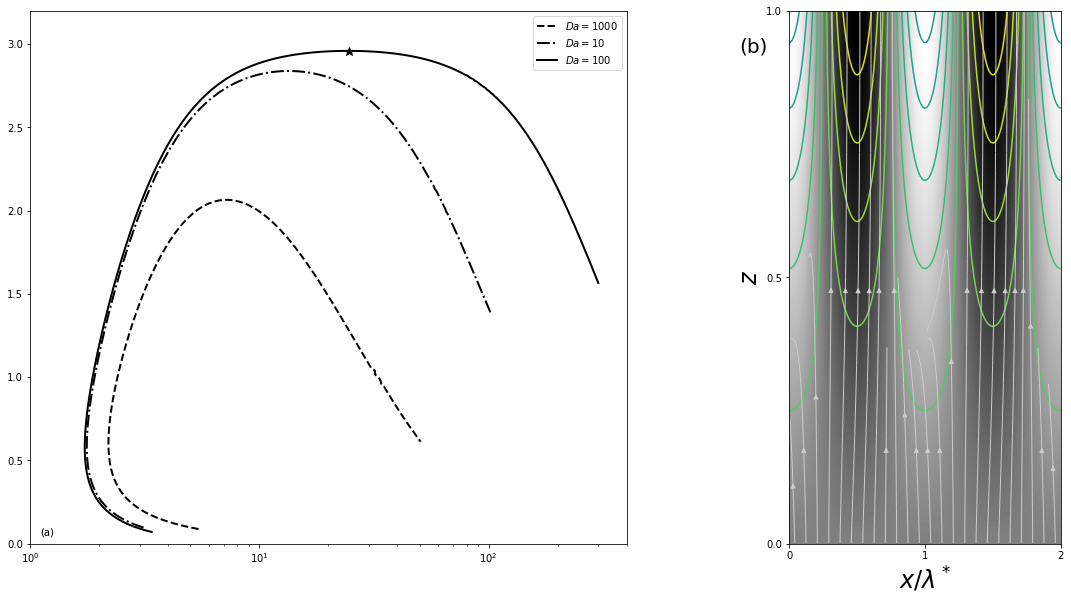

In [12]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(9.8 * zoom, 4.9 * zoom)
f.set_facecolor('w')

gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])

ax0 = plt.subplot(gs[0])
ax0.plot(DC_a.k, DC_a.s, '--k', linewidth=2, label=r'$Da=1000$')
ax0.plot(DC_b.k, DC_b.s, '-.k', linewidth=2, label=r'$Da=10$')
ax0.plot(DC_ref.k, DC_ref.s, '-k', linewidth=2, label=r'$Da=100$')
ax0.plot(DC_ref.k[iref], DC_ref.s[iref], '*k', MarkerSize=9)
ax0.set_xscale('log')
ax0.set_xlim(1.0, 400.0)
ax0.set_xticks((1e0, 1e1, 1e2))
ax0.set_ylim(0.0, 3.2)
ax0.text(1.1, 0.1, '(a)', verticalalignment='top', horizontalalignment='left')
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.imshow(np.flipud(P), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
ax1.contour(X, Z, phi, levels=np.linspace(-1, 1, 20))
nlines = 24
h = 2.0 * lambda_/(nlines+1.0)
seed = np.zeros((nlines, 2))
seed[:, 0] = np.linspace(0.5*h, 2.0*lambda_-0.5*h, nlines)
seed[:, 1] = np.ones_like(seed[:, 0]) / 1000.0
ax1.streamplot(X, Z, U, W, start_points=seed, integration_direction='forward', color=[0.8, 0.8, 0.8], linewidth=1)
ax1.set_xlabel(r'$x/\lambda^*$', fontsize=24)
ax1.set_xlim(0, 2.*lambda_)
ax1.set_xticks((0, lambda_, 2*lambda_))
ax1.set_xticklabels((0, 1, 2))
ax1.set_ylabel(r'$z$', fontsize=24)
ax1.set_ylim(0, 1)
ax1.set_yticks((0, 0.5, 1))
ax1.text(-0.04, 0.95, '(b)', fontsize=20, verticalalignment='top', horizontalalignment='right')

plt.show()

### The large-Damkohler number limit

In [13]:
Lkbounds = np.log10([0.1, 400.0])
sbounds = np.asarray([0.05, 4.0])
init_Lks = np.asarray([np.log10(5.0), 3.0])
DC_cube = {}
DC_quad = {}

for vals in [10., 100., 1000.]:
    par = PAR(Da_=vals, largeDa_=False)
    DC_cube[vals] = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)

    par = PAR(Da_=vals, largeDa_=True)
    DC_quad[vals] = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)

SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=1.9700163558867765
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=1.9570167816517678
Iteration 2: searching for solution at k=4.818066292998758
SUCCESS: monotonic eigenfunction for k=4.818066292998758, sigma=1.9486469892766827
Iteration 3: searching for solution at k=4.754040003771168
SUCCESS: monotonic eigenfunction for k=4.754040003771168, sigma=1.9403553170435563
Iteration 4: searching for solution at k=4.692426291378214
SUCCESS: monotonic eigenfunction for k=4.692426291378214, sigma=1.9319700450992363
Iteration 5: searching for solution at k=4.633064371552892
SUCCESS: monotonic eigenfunction for k=4.633064371552892, sigma=1.9234983480123409
Iteration 6: searching for solution at k=4.5758148172813105
SUCCESS: monotonic eigenfunction for k=4.5758148172813105, sigma=1.9149475845022907
Iteration 7: searching for solution at k=4.520549371340002
SUCC

SUCCESS: monotonic eigenfunction for k=2.9207714252179886, sigma=1.3987133986216935
Iteration 62: searching for solution at k=2.9039132773538574
SUCCESS: monotonic eigenfunction for k=2.9039132773538574, sigma=1.388986553341307
Iteration 63: searching for solution at k=2.8873073341723305
SUCCESS: monotonic eigenfunction for k=2.8873073341723305, sigma=1.3792538595402484
Iteration 64: searching for solution at k=2.87094845215095
SUCCESS: monotonic eigenfunction for k=2.87094845215095, sigma=1.3695154234075526
Iteration 65: searching for solution at k=2.8548316993555907
SUCCESS: monotonic eigenfunction for k=2.8548316993555907, sigma=1.3597713443328892
Iteration 66: searching for solution at k=2.838952347286206
SUCCESS: monotonic eigenfunction for k=2.838952347286206, sigma=1.3500217151417906
Iteration 67: searching for solution at k=2.823305863236351
SUCCESS: monotonic eigenfunction for k=2.823305863236351, sigma=1.340266622309983
Iteration 68: searching for solution at k=2.807887903136

SUCCESS: monotonic eigenfunction for k=2.2570328473925887, sigma=0.8053768183471879
Iteration 122: searching for solution at k=2.2514400744614735
SUCCESS: monotonic eigenfunction for k=2.2514400744614735, sigma=0.7952495356617809
Iteration 123: searching for solution at k=2.2460568201002693
SUCCESS: monotonic eigenfunction for k=2.2460568201002693, sigma=0.785104703985472
Iteration 124: searching for solution at k=2.2408880341772797
SUCCESS: monotonic eigenfunction for k=2.2408880341772797, sigma=0.7749405454125572
Iteration 125: searching for solution at k=2.2359390674761093
SUCCESS: monotonic eigenfunction for k=2.2359390674761093, sigma=0.7647549300583495
Iteration 126: searching for solution at k=2.231215706180977
SUCCESS: monotonic eigenfunction for k=2.231215706180977, sigma=0.7545452750089868
Iteration 127: searching for solution at k=2.226724211978989
SUCCESS: monotonic eigenfunction for k=2.226724211978989, sigma=0.7443084041151938
Iteration 128: searching for solution at k=2.

SUCCESS: monotonic eigenfunction for k=2.678246569762177, sigma=0.26167470340916216
Iteration 179: searching for solution at k=2.7154667569675945
SUCCESS: monotonic eigenfunction for k=2.7154667569675945, sigma=0.2538964612624246
Iteration 180: searching for solution at k=2.754638689963233
SUCCESS: monotonic eigenfunction for k=2.754638689963233, sigma=0.24628424430285917
Iteration 181: searching for solution at k=2.795798690536334
SUCCESS: monotonic eigenfunction for k=2.795798690536334, sigma=0.23884437930322364
Iteration 182: searching for solution at k=2.8389788840011714
SUCCESS: monotonic eigenfunction for k=2.8389788840011714, sigma=0.2315823699415709
Iteration 183: searching for solution at k=2.8842073575240548
SUCCESS: monotonic eigenfunction for k=2.8842073575240548, sigma=0.2245028229026245
Iteration 184: searching for solution at k=2.9315084388590464
SUCCESS: monotonic eigenfunction for k=2.9315084388590464, sigma=0.21760939741726623
Iteration 185: searching for solution at 

SUCCESS: monotonic eigenfunction for k=5.307540535674139, sigma=1.9995950848331292
Iteration 219: searching for solution at k=5.393405914221006
SUCCESS: monotonic eigenfunction for k=5.393405914221006, sigma=2.006554947329292
Iteration 220: searching for solution at k=5.48331794312552
SUCCESS: monotonic eigenfunction for k=5.48331794312552, sigma=2.0132937670130375
Iteration 221: searching for solution at k=5.577564058747568
SUCCESS: monotonic eigenfunction for k=5.577564058747568, sigma=2.0197865324564193
Iteration 222: searching for solution at k=5.6764453734025055
SUCCESS: monotonic eigenfunction for k=5.6764453734025055, sigma=2.0260049820274597
Iteration 223: searching for solution at k=5.780272024861768
SUCCESS: monotonic eigenfunction for k=5.780272024861768, sigma=2.0319173097030236
Iteration 224: searching for solution at k=5.88935582680387
SUCCESS: monotonic eigenfunction for k=5.88935582680387, sigma=2.0374879466329086
Iteration 225: searching for solution at k=6.00399941296

SUCCESS: monotonic eigenfunction for k=14.32275029949728, sigma=1.7791264306003756
Iteration 277: searching for solution at k=14.48600182610287
SUCCESS: monotonic eigenfunction for k=14.48600182610287, sigma=1.7703708732612318
Iteration 278: searching for solution at k=14.64962652472978
SUCCESS: monotonic eigenfunction for k=14.64962652472978, sigma=1.7615922279382563
Iteration 279: searching for solution at k=14.813654398587774
SUCCESS: monotonic eigenfunction for k=14.813654398587774, sigma=1.7527916791740121
Iteration 280: searching for solution at k=14.978114818013609
SUCCESS: monotonic eigenfunction for k=14.978114818013609, sigma=1.7439703356982856
Iteration 281: searching for solution at k=15.143036573978485
SUCCESS: monotonic eigenfunction for k=15.143036573978485, sigma=1.7351292367814857
Iteration 282: searching for solution at k=15.308447928546636
SUCCESS: monotonic eigenfunction for k=15.308447928546636, sigma=1.7262693579564055
Iteration 283: searching for solution at k=15

SUCCESS: monotonic eigenfunction for k=25.46188535008186, sigma=1.2437506850060127
Iteration 336: searching for solution at k=25.69342196127764
SUCCESS: monotonic eigenfunction for k=25.69342196127764, sigma=1.234555625585348
Iteration 337: searching for solution at k=25.927041115281583
SUCCESS: monotonic eigenfunction for k=25.927041115281583, sigma=1.2253609190556738
Iteration 338: searching for solution at k=26.16278392376278
SUCCESS: monotonic eigenfunction for k=26.16278392376278, sigma=1.2161667229456719
Iteration 339: searching for solution at k=26.400692355196142
SUCCESS: monotonic eigenfunction for k=26.400692355196142, sigma=1.206973194096563
Iteration 340: searching for solution at k=26.64080926402617
SUCCESS: monotonic eigenfunction for k=26.64080926402617, sigma=1.1977804888138661
Iteration 341: searching for solution at k=26.883178420723123
SUCCESS: monotonic eigenfunction for k=26.883178420723123, sigma=1.188588763016497
Iteration 342: searching for solution at k=27.1278

FAILURE: no solution found for k=37.197521207422966
Iteration 372: searching for solution at k=37.197521207422966
FAILURE: no solution found for k=37.197521207422966
Iteration 372: searching for solution at sigma=0.8813194555832876
SUCCESS: monotonic eigenfunction for k=37.198412338626106, sigma=0.8813194555832876
Iteration 373: searching for solution at k=37.55014147435615
FAILURE: no solution found for k=37.55014147435615
Iteration 373: searching for solution at k=37.55014147435615
FAILURE: no solution found for k=37.55014147435615
Iteration 373: searching for solution at sigma=0.8721928312731445
SUCCESS: monotonic eigenfunction for k=37.55106409072905, sigma=0.8721928312731445
Iteration 374: searching for solution at k=37.90765899676377
FAILURE: no solution found for k=37.90765899676377
Iteration 374: searching for solution at k=37.90765899676377
FAILURE: no solution found for k=37.90765899676377
Iteration 374: searching for solution at sigma=0.8630740830740523
SUCCESS: monotonic ei

FAILURE: no solution found for k=46.290423296352195
Iteration 394: searching for solution at k=46.290423296352195
FAILURE: no solution found for k=46.290423296352195
Iteration 394: searching for solution at sigma=0.6827624130273926
SUCCESS: monotonic eigenfunction for k=46.29234992546921, sigma=0.6827624130273926
Iteration 395: searching for solution at k=46.78346496832992
FAILURE: no solution found for k=46.78346496832992
Iteration 395: searching for solution at k=46.78346496832992
FAILURE: no solution found for k=46.78346496832992
Iteration 395: searching for solution at sigma=0.6738744767640027
SUCCESS: monotonic eigenfunction for k=46.78546242179079, sigma=0.6738744767640027
Iteration 396: searching for solution at k=47.28495389807136
FAILURE: no solution found for k=47.28495389807136
Iteration 396: searching for solution at k=47.28495389807136
FAILURE: no solution found for k=47.28495389807136
Iteration 396: searching for solution at sigma=0.6650014937134047
SUCCESS: monotonic eig

SUCCESS: monotonic eigenfunction for k=3.227993394106238, sigma=1.8728414628971317
Iteration 35: searching for solution at k=3.2001128566670842
SUCCESS: monotonic eigenfunction for k=3.2001128566670842, sigma=1.8634991351129477
Iteration 36: searching for solution at k=3.172878060736905
SUCCESS: monotonic eigenfunction for k=3.172878060736905, sigma=1.8541361150508904
Iteration 37: searching for solution at k=3.146263244102575
SUCCESS: monotonic eigenfunction for k=3.146263244102575, sigma=1.8447534257525846
Iteration 38: searching for solution at k=3.1202441745892946
SUCCESS: monotonic eigenfunction for k=3.1202441745892946, sigma=1.83535201588233
Iteration 39: searching for solution at k=3.094798035048071
SUCCESS: monotonic eigenfunction for k=3.094798035048071, sigma=1.825932766343003
Iteration 40: searching for solution at k=3.0699033188711224
SUCCESS: monotonic eigenfunction for k=3.0699033188711224, sigma=1.8164964961798553
Iteration 41: searching for solution at k=3.045539734927

SUCCESS: monotonic eigenfunction for k=2.2431438831767854, sigma=1.312170701635889
Iteration 93: searching for solution at k=2.2332182848640403
SUCCESS: monotonic eigenfunction for k=2.2332182848640403, sigma=1.302291821296907
Iteration 94: searching for solution at k=2.2234625156275487
SUCCESS: monotonic eigenfunction for k=2.2234625156275487, sigma=1.292406768925367
Iteration 95: searching for solution at k=2.213875686110768
SUCCESS: monotonic eigenfunction for k=2.213875686110768, sigma=1.2825154659842963
Iteration 96: searching for solution at k=2.2044570409634057
SUCCESS: monotonic eigenfunction for k=2.2044570409634057, sigma=1.2726178235727093
Iteration 97: searching for solution at k=2.195205959829452
SUCCESS: monotonic eigenfunction for k=2.195205959829452, sigma=1.2627137417737577
Iteration 98: searching for solution at k=2.1861219586783713
SUCCESS: monotonic eigenfunction for k=2.1861219586783713, sigma=1.2528031089076734
Iteration 99: searching for solution at k=2.177204691

SUCCESS: monotonic eigenfunction for k=1.9912206463764766, sigma=0.7648133558239031
Iteration 148: searching for solution at k=1.9947742690121422
SUCCESS: monotonic eigenfunction for k=1.9947742690121422, sigma=0.75547347695336
Iteration 149: searching for solution at k=1.9988354503607246
SUCCESS: monotonic eigenfunction for k=1.9988354503607246, sigma=0.746098693226321
Iteration 150: searching for solution at k=2.0034318446076798
SUCCESS: monotonic eigenfunction for k=2.0034318446076798, sigma=0.7366979980655319
Iteration 151: searching for solution at k=2.008592609095843
SUCCESS: monotonic eigenfunction for k=2.008592609095843, sigma=0.7272789998491549
Iteration 152: searching for solution at k=2.01434856268273
SUCCESS: monotonic eigenfunction for k=2.01434856268273, sigma=0.7178483670240565
Iteration 153: searching for solution at k=2.0207323262900174
SUCCESS: monotonic eigenfunction for k=2.0207323262900174, sigma=0.7084121435836154
Iteration 154: searching for solution at k=2.0277

SUCCESS: monotonic eigenfunction for k=4.222098824352827, sigma=0.3680305853358258
Iteration 205: searching for solution at k=4.3169568410096835
SUCCESS: monotonic eigenfunction for k=4.3169568410096835, sigma=0.3654580070455055
Iteration 206: searching for solution at k=4.414229514690119
FAILURE: no solution found for k=4.414229514690119
Iteration 206: searching for solution at k=4.414229514690119
FAILURE: no solution found for k=4.414229514690119
Iteration 206: searching for solution at sigma=0.36293588267813404
SUCCESS: monotonic eigenfunction for k=4.416317729150877, sigma=0.36293588267813404
Iteration 207: searching for solution at k=4.5160952391686235
SUCCESS: monotonic eigenfunction for k=4.5160952391686235, sigma=0.3605635658432542
Iteration 208: searching for solution at k=4.6183736245962725
SUCCESS: monotonic eigenfunction for k=4.6183736245962725, sigma=0.35828238901963017
Iteration 209: searching for solution at k=4.7231945543781695
SUCCESS: monotonic eigenfunction for k=4.

FAILURE: no solution found for k=8.36441249296964
Iteration 234: searching for solution at sigma=0.3174896000148565
FAILURE: no solution found for k=[8.18862697 8.21184988 8.23513865 8.25849346 8.28191451 8.30540198
 8.32895606 8.35257694 8.37626481 8.40001986 8.42384228 8.44773225
 8.47168998 8.49571566 8.51980947 8.54397161]
Iteration 234: searching for solution at k=5.099425269147539
SUCCESS: monotonic eigenfunction for k=5.099425269147539, sigma=2.1606709254178904
Iteration 235: searching for solution at k=5.204525568657401
SUCCESS: monotonic eigenfunction for k=5.204525568657401, sigma=2.164977739536996
Iteration 236: searching for solution at k=5.3151427411236885
SUCCESS: monotonic eigenfunction for k=5.3151427411236885, sigma=2.1687074463563234
Iteration 237: searching for solution at k=5.431337831049093
SUCCESS: monotonic eigenfunction for k=5.431337831049093, sigma=2.171795047190751
Iteration 238: searching for solution at k=5.553018208558282
SUCCESS: monotonic eigenfunction f

SUCCESS: monotonic eigenfunction for k=11.747069531876138, sigma=1.8167713940029657
Iteration 290: searching for solution at k=11.857490191754252
SUCCESS: monotonic eigenfunction for k=11.857490191754252, sigma=1.8075926179743702
Iteration 291: searching for solution at k=11.968086282383034
SUCCESS: monotonic eigenfunction for k=11.968086282383034, sigma=1.7984015531536135
Iteration 292: searching for solution at k=12.078881240387505
SUCCESS: monotonic eigenfunction for k=12.078881240387505, sigma=1.7891988720128325
Iteration 293: searching for solution at k=12.189898100132199
SUCCESS: monotonic eigenfunction for k=12.189898100132199, sigma=1.779985208476303
Iteration 294: searching for solution at k=12.301159535853968
SUCCESS: monotonic eigenfunction for k=12.301159535853968, sigma=1.7707611610175458
Iteration 295: searching for solution at k=12.412687901328567
SUCCESS: monotonic eigenfunction for k=12.412687901328567, sigma=1.76152729546793
Iteration 296: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=19.29023345912542, sigma=1.266963920922395
Iteration 349: searching for solution at k=19.451034257296406
SUCCESS: monotonic eigenfunction for k=19.451034257296406, sigma=1.2576504225994096
Iteration 350: searching for solution at k=19.613590761853956
SUCCESS: monotonic eigenfunction for k=19.613590761853956, sigma=1.2483411969632343
Iteration 351: searching for solution at k=19.77794743817124
SUCCESS: monotonic eigenfunction for k=19.77794743817124, sigma=1.2390364489327497
Iteration 352: searching for solution at k=19.944149938649822
SUCCESS: monotonic eigenfunction for k=19.944149938649822, sigma=1.2297363864009576
Iteration 353: searching for solution at k=20.11224514469229
SUCCESS: monotonic eigenfunction for k=20.11224514469229, sigma=1.2204412204263642
Iteration 354: searching for solution at k=20.28228120990016
SUCCESS: monotonic eigenfunction for k=20.28228120990016, sigma=1.2111511654246179
Iteration 355: searching for solution at k=20.45

SUCCESS: monotonic eigenfunction for k=33.24610565967361, sigma=0.7508184819718048
Iteration 406: searching for solution at k=33.633776806437545
SUCCESS: monotonic eigenfunction for k=33.633776806437545, sigma=0.7422259731149073
Iteration 407: searching for solution at k=34.02921727097307
SUCCESS: monotonic eigenfunction for k=34.02921727097307, sigma=0.7336578862724649
Iteration 408: searching for solution at k=34.43262201567823
SUCCESS: monotonic eigenfunction for k=34.43262201567823, sigma=0.7251146644076883
Iteration 409: searching for solution at k=34.844189208542694
SUCCESS: monotonic eigenfunction for k=34.844189208542694, sigma=0.7165967413885098
Iteration 410: searching for solution at k=35.264120162079315
SUCCESS: monotonic eigenfunction for k=35.264120162079315, sigma=0.708104540801457
Iteration 411: searching for solution at k=35.69261927239635
SUCCESS: monotonic eigenfunction for k=35.69261927239635, sigma=0.6996384747844313
Iteration 412: searching for solution at k=36.12

SUCCESS: monotonic eigenfunction for k=3.989480531823379, sigma=2.35099952020404
Iteration 22: searching for solution at k=3.9544491211263844
SUCCESS: monotonic eigenfunction for k=3.9544491211263844, sigma=2.3416992316588896
Iteration 23: searching for solution at k=3.9201279716528803
SUCCESS: monotonic eigenfunction for k=3.9201279716528803, sigma=2.3323814946789887
Iteration 24: searching for solution at k=3.8864942489013123
SUCCESS: monotonic eigenfunction for k=3.8864942489013123, sigma=2.3230469753302216
Iteration 25: searching for solution at k=3.8535260699399645
SUCCESS: monotonic eigenfunction for k=3.8535260699399645, sigma=2.3136963077177906
Iteration 26: searching for solution at k=3.821202457353249
SUCCESS: monotonic eigenfunction for k=3.821202457353249, sigma=2.304330095743331
Iteration 27: searching for solution at k=3.789503295585066
SUCCESS: monotonic eigenfunction for k=3.789503295585066, sigma=2.2949489147570956
Iteration 28: searching for solution at k=3.7584092895

SUCCESS: monotonic eigenfunction for k=2.660196615408611, sigma=1.7753927295170886
Iteration 82: searching for solution at k=2.646133081014251
SUCCESS: monotonic eigenfunction for k=2.646133081014251, sigma=1.7656293263206282
Iteration 83: searching for solution at k=2.6322307862129226
SUCCESS: monotonic eigenfunction for k=2.6322307862129226, sigma=1.7558627594503837
Iteration 84: searching for solution at k=2.618486871226649
SUCCESS: monotonic eigenfunction for k=2.618486871226649, sigma=1.746093085667782
Iteration 85: searching for solution at k=2.604898557839837
SUCCESS: monotonic eigenfunction for k=2.604898557839837, sigma=1.7363203595493206
Iteration 86: searching for solution at k=2.591463146906145
SUCCESS: monotonic eigenfunction for k=2.591463146906145, sigma=1.7265446335495005
Iteration 87: searching for solution at k=2.5781780159600043
SUCCESS: monotonic eigenfunction for k=2.5781780159600043, sigma=1.7167659580603998
Iteration 88: searching for solution at k=2.565040616928

SUCCESS: monotonic eigenfunction for k=2.0569486025331725, sigma=1.2147924495231681
Iteration 139: searching for solution at k=2.0492382456517295
SUCCESS: monotonic eigenfunction for k=2.0492382456517295, sigma=1.2048891496739778
Iteration 140: searching for solution at k=2.0416124257060133
SUCCESS: monotonic eigenfunction for k=2.0416124257060133, sigma=1.1949832532366111
Iteration 141: searching for solution at k=2.034070957762407
SUCCESS: monotonic eigenfunction for k=2.034070957762407, sigma=1.1850747178686631
Iteration 142: searching for solution at k=2.0266136953177627
SUCCESS: monotonic eigenfunction for k=2.0266136953177627, sigma=1.1751634983209491
Iteration 143: searching for solution at k=2.0192405309305532
SUCCESS: monotonic eigenfunction for k=2.0192405309305532, sigma=1.1652495462880141
Iteration 144: searching for solution at k=2.011951396915527
SUCCESS: monotonic eigenfunction for k=2.011951396915527, sigma=1.155332810245213
Iteration 145: searching for solution at k=2.

SUCCESS: monotonic eigenfunction for k=1.7687459835121162, sigma=0.6402480616744263
Iteration 196: searching for solution at k=1.7674782307191812
SUCCESS: monotonic eigenfunction for k=1.7674782307191812, sigma=0.6291553267639091
Iteration 197: searching for solution at k=1.7664378183008078
SUCCESS: monotonic eigenfunction for k=1.7664378183008078, sigma=0.6176233673970021
Iteration 198: searching for solution at k=1.7656421644881182
SUCCESS: monotonic eigenfunction for k=1.7656421644881182, sigma=0.6050769410800082
Iteration 199: searching for solution at k=1.7651193105750522
FAILURE: no solution found for k=1.7651193105750522
Iteration 199: searching for solution at k=1.7651193105750522
FAILURE: no solution found for k=1.7651193105750522
Iteration 199: searching for solution at sigma=0.5950776412124293
SUCCESS: monotonic eigenfunction for k=1.76527060049848, sigma=0.5950776412124293
Iteration 200: searching for solution at k=1.765015405546866
FAILURE: no solution found for k=1.765015

SUCCESS: monotonic eigenfunction for k=2.421812000582036, sigma=0.1636194767960338
Iteration 249: searching for solution at k=2.4642857278877304
SUCCESS: monotonic eigenfunction for k=2.4642857278877304, sigma=0.1572407633912133
Iteration 250: searching for solution at k=2.5085653228971196
SUCCESS: monotonic eigenfunction for k=2.5085653228971196, sigma=0.15107189964345905
Iteration 251: searching for solution at k=2.554663568319601
SUCCESS: monotonic eigenfunction for k=2.554663568319601, sigma=0.14511365335954018
Iteration 252: searching for solution at k=2.602591359427536
SUCCESS: monotonic eigenfunction for k=2.602591359427536, sigma=0.13936574925323936
Iteration 253: searching for solution at k=2.6523582160334196
SUCCESS: monotonic eigenfunction for k=2.6523582160334196, sigma=0.133826933141076
Iteration 254: searching for solution at k=2.7039727869086816
SUCCESS: monotonic eigenfunction for k=2.7039727869086816, sigma=0.12849505241992684
Iteration 255: searching for solution at k

SUCCESS: monotonic eigenfunction for k=9.658536131363187, sigma=2.8132757113681626
Iteration 302: searching for solution at k=9.869319228992392
SUCCESS: monotonic eigenfunction for k=9.869319228992392, sigma=2.816631849012395
Iteration 303: searching for solution at k=10.086582710091177
SUCCESS: monotonic eigenfunction for k=10.086582710091177, sigma=2.819762277881454
Iteration 304: searching for solution at k=10.310430642490983
SUCCESS: monotonic eigenfunction for k=10.310430642490983, sigma=2.822663950329996
Iteration 305: searching for solution at k=10.540960448941307
SUCCESS: monotonic eigenfunction for k=10.540960448941307, sigma=2.8253341172084077
Iteration 306: searching for solution at k=10.77826258296226
SUCCESS: monotonic eigenfunction for k=10.77826258296226, sigma=2.827770322349969
Iteration 307: searching for solution at k=11.022420200969751
SUCCESS: monotonic eigenfunction for k=11.022420200969751, sigma=2.8299703938762675
Iteration 308: searching for solution at k=11.273

SUCCESS: monotonic eigenfunction for k=31.113271984649803, sigma=2.648004835056789
Iteration 359: searching for solution at k=31.578397102084164
SUCCESS: monotonic eigenfunction for k=31.578397102084164, sigma=2.6402612897286906
Iteration 360: searching for solution at k=32.0434337321328
SUCCESS: monotonic eigenfunction for k=32.0434337321328, sigma=2.6324400533295975
Iteration 361: searching for solution at k=32.50833135139736
SUCCESS: monotonic eigenfunction for k=32.50833135139736, sigma=2.6245447681255274
Iteration 362: searching for solution at k=32.97304695652772
SUCCESS: monotonic eigenfunction for k=32.97304695652772, sigma=2.6165789082863853
Iteration 363: searching for solution at k=33.43754453497307
SUCCESS: monotonic eigenfunction for k=33.43754453497307, sigma=2.6085457843398108
Iteration 364: searching for solution at k=33.90179455259517
SUCCESS: monotonic eigenfunction for k=33.90179455259517, sigma=2.6004485481374133
Iteration 365: searching for solution at k=34.3657734

SUCCESS: monotonic eigenfunction for k=58.03982509243926, sigma=2.133503957459131
Iteration 414: searching for solution at k=58.2825758937672
SUCCESS: monotonic eigenfunction for k=58.2825758937672, sigma=2.1287144056090765
Iteration 415: searching for solution at k=58.803617707792874
FAILURE: non-monotonic eigenfunction for k=58.803617707792874, sigma=2.099506504199964
Iteration 415: searching for solution at k=58.803617707792874
FAILURE: non-monotonic eigenfunction for k=58.803617707792874, sigma=2.099506504199964
Iteration 415: searching for solution at sigma=2.1194670415237575
SUCCESS: monotonic eigenfunction for k=59.06897254606106, sigma=2.1194670415237575
Iteration 416: searching for solution at k=59.951523276673946
FAILURE: no solution found for k=59.951523276673946
Iteration 416: searching for solution at k=59.951523276673946
FAILURE: no solution found for k=59.951523276673946
Iteration 416: searching for solution at sigma=2.1115583223700276
SUCCESS: monotonic eigenfunction fo

FAILURE: no solution found for k=69.47884388741404
Iteration 436: searching for solution at sigma=1.9174799064396566
SUCCESS: monotonic eigenfunction for k=69.47789085062419, sigma=1.9174799064396566
Iteration 437: searching for solution at k=69.98426890174167
FAILURE: no solution found for k=69.98426890174167
Iteration 437: searching for solution at k=69.98426890174167
FAILURE: no solution found for k=69.98426890174167
Iteration 437: searching for solution at sigma=1.9079902477555701
SUCCESS: monotonic eigenfunction for k=69.98333693664281, sigma=1.9079902477555701
Iteration 438: searching for solution at k=70.49168159231861
FAILURE: no solution found for k=70.49168159231861
Iteration 438: searching for solution at k=70.49168159231861
FAILURE: no solution found for k=70.49168159231861
Iteration 438: searching for solution at sigma=1.8984970798280336
SUCCESS: monotonic eigenfunction for k=70.49077057633589, sigma=1.8984970798280336
Iteration 439: searching for solution at k=71.00112099

FAILURE: no solution found for k=81.12096314110435
Iteration 458: searching for solution at sigma=1.7080538741056677
SUCCESS: monotonic eigenfunction for k=81.12046021149044, sigma=1.7080538741056677
Iteration 459: searching for solution at k=81.67989842129147
FAILURE: no solution found for k=81.67989842129147
Iteration 459: searching for solution at k=81.67989842129147
FAILURE: no solution found for k=81.67989842129147
Iteration 459: searching for solution at sigma=1.6985097088039276
SUCCESS: monotonic eigenfunction for k=81.67941607743053, sigma=1.6985097088039276
Iteration 460: searching for solution at k=82.24180183916447
FAILURE: no solution found for k=82.24180183916447
Iteration 460: searching for solution at k=82.24180183916447
FAILURE: no solution found for k=82.24180183916447
Iteration 460: searching for solution at sigma=1.6889640466915732
SUCCESS: monotonic eigenfunction for k=82.24134016789402, sigma=1.6889640466915732
Iteration 461: searching for solution at k=82.80672544

FAILURE: no solution found for k=94.82757640492945
Iteration 481: searching for solution at sigma=1.4882845353672574
SUCCESS: monotonic eigenfunction for k=94.82758755232398, sigma=1.4882845353672574
Iteration 482: searching for solution at k=95.46960193361609
FAILURE: no solution found for k=95.46960193361609
Iteration 482: searching for solution at k=95.46960193361609
FAILURE: no solution found for k=95.46960193361609
Iteration 482: searching for solution at sigma=1.4787235365048068
SUCCESS: monotonic eigenfunction for k=95.4696384243747, sigma=1.4787235365048068
Iteration 483: searching for solution at k=96.11604360949573
FAILURE: no solution found for k=96.11604360949573
Iteration 483: searching for solution at k=96.11604360949573
FAILURE: no solution found for k=96.11604360949573
Iteration 483: searching for solution at sigma=1.469162598448705
SUCCESS: monotonic eigenfunction for k=96.11610580233116, sigma=1.469162598448705
Iteration 484: searching for solution at k=96.76697913397

SUCCESS: monotonic eigenfunction for k=3.867994429853827, sigma=2.339278270594354
Iteration 25: searching for solution at k=3.8345956377920007
SUCCESS: monotonic eigenfunction for k=3.8345956377920007, sigma=2.329953101504481
Iteration 26: searching for solution at k=3.8018615335151593
SUCCESS: monotonic eigenfunction for k=3.8018615335151593, sigma=2.3206114622362652
Iteration 27: searching for solution at k=3.769771083063956
SUCCESS: monotonic eigenfunction for k=3.769771083063956, sigma=2.3112539709239845
Iteration 28: searching for solution at k=3.7383041187232977
SUCCESS: monotonic eigenfunction for k=3.7383041187232977, sigma=2.3018812164127564
Iteration 29: searching for solution at k=3.707441297431457
SUCCESS: monotonic eigenfunction for k=3.707441297431457, sigma=2.2924937598522748
Iteration 30: searching for solution at k=3.6771640613535497
SUCCESS: monotonic eigenfunction for k=3.6771640613535497, sigma=2.2830921361957612
Iteration 31: searching for solution at k=3.647454600

SUCCESS: monotonic eigenfunction for k=2.605751681247089, sigma=1.7727856322177267
Iteration 84: searching for solution at k=2.592011892397618
SUCCESS: monotonic eigenfunction for k=2.592011892397618, sigma=1.7630207989810218
Iteration 85: searching for solution at k=2.57842946628999
SUCCESS: monotonic eigenfunction for k=2.57842946628999, sigma=1.753252809707869
Iteration 86: searching for solution at k=2.56500163836596
SUCCESS: monotonic eigenfunction for k=2.56500163836596, sigma=1.7434817196564456
Iteration 87: searching for solution at k=2.551725723185223
SUCCESS: monotonic eigenfunction for k=2.551725723185223, sigma=1.7337075819149197
Iteration 88: searching for solution at k=2.538599112034343
SUCCESS: monotonic eigenfunction for k=2.538599112034343, sigma=1.7239304474620962
Iteration 89: searching for solution at k=2.525619270636577
SUCCESS: monotonic eigenfunction for k=2.525619270636577, sigma=1.7141503652247785
Iteration 90: searching for solution at k=2.512783736958324
SUCC

SUCCESS: monotonic eigenfunction for k=2.0245998465783352, sigma=1.2220957000623387
Iteration 140: searching for solution at k=2.0170174781367898
SUCCESS: monotonic eigenfunction for k=2.0170174781367898, sigma=1.212191206622131
Iteration 141: searching for solution at k=2.009519600646485
SUCCESS: monotonic eigenfunction for k=2.009519600646485, sigma=1.2022840293242067
Iteration 142: searching for solution at k=2.002106057082518
SUCCESS: monotonic eigenfunction for k=2.002106057082518, sigma=1.1923741227171938
Iteration 143: searching for solution at k=1.9947767297846206
SUCCESS: monotonic eigenfunction for k=1.9947767297846206, sigma=1.1824614382455259
Iteration 144: searching for solution at k=1.9875315411437071
SUCCESS: monotonic eigenfunction for k=1.9875315411437071, sigma=1.1725459240845646
Iteration 145: searching for solution at k=1.9803704543554184
SUCCESS: monotonic eigenfunction for k=1.9803704543554184, sigma=1.162627524960644
Iteration 146: searching for solution at k=1.9

SUCCESS: monotonic eigenfunction for k=1.7453439633491137, sigma=0.6461793885918508
Iteration 197: searching for solution at k=1.744349104359411
SUCCESS: monotonic eigenfunction for k=1.744349104359411, sigma=0.6345406313933704
Iteration 198: searching for solution at k=1.7436008820987543
SUCCESS: monotonic eigenfunction for k=1.7436008820987543, sigma=0.621678694170543
Iteration 199: searching for solution at k=1.743130572203998
FAILURE: no solution found for k=1.743130572203998
Iteration 199: searching for solution at k=1.743130572203998
FAILURE: no solution found for k=1.743130572203998
Iteration 199: searching for solution at sigma=0.6116792481766855
SUCCESS: monotonic eigenfunction for k=1.7432858990688969, sigma=0.6116792481766855
Iteration 200: searching for solution at k=1.7430875031866153
FAILURE: no solution found for k=1.7430875031866153
Iteration 200: searching for solution at k=1.7430875031866153
FAILURE: no solution found for k=1.7430875031866153
Iteration 200: searching 

SUCCESS: monotonic eigenfunction for k=2.465834516125023, sigma=0.1714415848522259
Iteration 251: searching for solution at k=2.510827699561587
SUCCESS: monotonic eigenfunction for k=2.510827699561587, sigma=0.16541495345908244
Iteration 252: searching for solution at k=2.557625521421774
SUCCESS: monotonic eigenfunction for k=2.557625521421774, sigma=0.15959880057065656
Iteration 253: searching for solution at k=2.6062386264980626
SUCCESS: monotonic eigenfunction for k=2.6062386264980626, sigma=0.15399236430376068
Iteration 254: searching for solution at k=2.6566766365611056
SUCCESS: monotonic eigenfunction for k=2.6566766365611056, sigma=0.14859397375308503
Iteration 255: searching for solution at k=2.7089486148870185
SUCCESS: monotonic eigenfunction for k=2.7089486148870185, sigma=0.14340113288273681
Iteration 256: searching for solution at k=2.763063500470052
SUCCESS: monotonic eigenfunction for k=2.763063500470052, sigma=0.13841061269861532
Iteration 257: searching for solution at 

SUCCESS: monotonic eigenfunction for k=6.041153788767998, sigma=2.6753848184687263
Iteration 307: searching for solution at k=6.134015474597571
SUCCESS: monotonic eigenfunction for k=6.134015474597571, sigma=2.6827639038449305
Iteration 308: searching for solution at k=6.229900543862218
SUCCESS: monotonic eigenfunction for k=6.229900543862218, sigma=2.690041774458895
Iteration 309: searching for solution at k=6.328930715544006
SUCCESS: monotonic eigenfunction for k=6.328930715544006, sigma=2.6972137955740965
Iteration 310: searching for solution at k=6.43123140775297
SUCCESS: monotonic eigenfunction for k=6.43123140775297, sigma=2.704275175020903
Iteration 311: searching for solution at k=6.5369315939002535
SUCCESS: monotonic eigenfunction for k=6.5369315939002535, sigma=2.7112209698954803
Iteration 312: searching for solution at k=6.646163619736472
SUCCESS: monotonic eigenfunction for k=6.646163619736472, sigma=2.718046095346489
Iteration 313: searching for solution at k=6.75906297930

SUCCESS: monotonic eigenfunction for k=20.499995747455202, sigma=2.7974389261704675
Iteration 366: searching for solution at k=20.926695607327797
SUCCESS: monotonic eigenfunction for k=20.926695607327797, sigma=2.792842866869659
Iteration 367: searching for solution at k=21.35728112772047
SUCCESS: monotonic eigenfunction for k=21.35728112772047, sigma=2.788049488507372
Iteration 368: searching for solution at k=21.791483849249015
SUCCESS: monotonic eigenfunction for k=21.791483849249015, sigma=2.783063864210636
Iteration 369: searching for solution at k=22.229036160971198
SUCCESS: monotonic eigenfunction for k=22.229036160971198, sigma=2.7778912692416724
Iteration 370: searching for solution at k=22.669673168548186
SUCCESS: monotonic eigenfunction for k=22.669673168548186, sigma=2.7725371512676773
Iteration 371: searching for solution at k=23.113134455656645
SUCCESS: monotonic eigenfunction for k=23.113134455656645, sigma=2.767007098937862
Iteration 372: searching for solution at k=23.

SUCCESS: monotonic eigenfunction for k=48.67582653019525, sigma=2.3141770544689346
Iteration 428: searching for solution at k=49.132050058666586
SUCCESS: monotonic eigenfunction for k=49.132050058666586, sigma=2.30498909247556
Iteration 429: searching for solution at k=49.58868011494983
SUCCESS: monotonic eigenfunction for k=49.58868011494983, sigma=2.295787089034394
Iteration 430: searching for solution at k=50.04575167154014
SUCCESS: monotonic eigenfunction for k=50.04575167154014, sigma=2.2865715644317577
Iteration 431: searching for solution at k=50.50329977780855
SUCCESS: monotonic eigenfunction for k=50.50329977780855, sigma=2.277343016254059
Iteration 432: searching for solution at k=50.96135954939752
SUCCESS: monotonic eigenfunction for k=50.96135954939752, sigma=2.268101920584759
Iteration 433: searching for solution at k=51.41996615968455
SUCCESS: monotonic eigenfunction for k=51.41996615968455, sigma=2.258848733131881
Iteration 434: searching for solution at k=51.87915483312

SUCCESS: monotonic eigenfunction for k=4.2601910046822, sigma=2.4626825860171735
Iteration 15: searching for solution at k=4.2195393857819115
SUCCESS: monotonic eigenfunction for k=4.2195393857819115, sigma=2.4535224978328136
Iteration 16: searching for solution at k=4.179773523794831
SUCCESS: monotonic eigenfunction for k=4.179773523794831, sigma=2.444339872190113
Iteration 17: searching for solution at k=4.140863821190263
SUCCESS: monotonic eigenfunction for k=4.140863821190263, sigma=2.4351355963730192
Iteration 18: searching for solution at k=4.102781909082086
SUCCESS: monotonic eigenfunction for k=4.102781909082086, sigma=2.4259105157282477
Iteration 19: searching for solution at k=4.065500591514655
SUCCESS: monotonic eigenfunction for k=4.065500591514655, sigma=2.4166654358000814
Iteration 20: searching for solution at k=4.028993792115858
SUCCESS: monotonic eigenfunction for k=4.028993792115858, sigma=2.407401124362135
Iteration 21: searching for solution at k=3.993236503066313
S

SUCCESS: monotonic eigenfunction for k=2.7640843409587523, sigma=1.8908742757431407
Iteration 75: searching for solution at k=2.7487404314642503
SUCCESS: monotonic eigenfunction for k=2.7487404314642503, sigma=1.8811375190217423
Iteration 76: searching for solution at k=2.7335804011509564
SUCCESS: monotonic eigenfunction for k=2.7335804011509564, sigma=1.871397150214491
Iteration 77: searching for solution at k=2.7186007192569766
SUCCESS: monotonic eigenfunction for k=2.7186007192569766, sigma=1.8616532446827927
Iteration 78: searching for solution at k=2.7037979564641645
SUCCESS: monotonic eigenfunction for k=2.7037979564641645, sigma=1.851905875102342
Iteration 79: searching for solution at k=2.6891687815679095
SUCCESS: monotonic eigenfunction for k=2.6891687815679095, sigma=1.84215511155333
Iteration 80: searching for solution at k=2.6747099582854172
SUCCESS: monotonic eigenfunction for k=2.6747099582854172, sigma=1.832401021606297
Iteration 81: searching for solution at k=2.6604183

SUCCESS: monotonic eigenfunction for k=2.109571280081781, sigma=1.331515409629655
Iteration 132: searching for solution at k=2.10114517591913
SUCCESS: monotonic eigenfunction for k=2.10114517591913, sigma=1.3216367148098027
Iteration 133: searching for solution at k=2.092803335053066
SUCCESS: monotonic eigenfunction for k=2.092803335053066, sigma=1.3117558587203744
Iteration 134: searching for solution at k=2.0845452179171238
SUCCESS: monotonic eigenfunction for k=2.0845452179171238, sigma=1.3018728245940498
Iteration 135: searching for solution at k=2.076370316953311
SUCCESS: monotonic eigenfunction for k=2.076370316953311, sigma=1.2919875939345693
Iteration 136: searching for solution at k=2.0682781566862527
SUCCESS: monotonic eigenfunction for k=2.0682781566862527, sigma=1.282100146461513
Iteration 137: searching for solution at k=2.0602682938359234
SUCCESS: monotonic eigenfunction for k=2.0602682938359234, sigma=1.2722104600505193
Iteration 138: searching for solution at k=2.052340

SUCCESS: monotonic eigenfunction for k=1.7628626336440492, sigma=0.7631214155977833
Iteration 189: searching for solution at k=1.759589323826735
SUCCESS: monotonic eigenfunction for k=1.759589323826735, sigma=0.752946707741758
Iteration 190: searching for solution at k=1.7564497752472656
SUCCESS: monotonic eigenfunction for k=1.7564497752472656, sigma=0.7427523525765867
Iteration 191: searching for solution at k=1.7534480208491914
SUCCESS: monotonic eigenfunction for k=1.7534480208491914, sigma=0.732535858421413
Iteration 192: searching for solution at k=1.7505883762952013
SUCCESS: monotonic eigenfunction for k=1.7505883762952013, sigma=0.7222941733787355
Iteration 193: searching for solution at k=1.7478754682626538
SUCCESS: monotonic eigenfunction for k=1.7478754682626538, sigma=0.7120235012036777
Iteration 194: searching for solution at k=1.7453142682775513
SUCCESS: monotonic eigenfunction for k=1.7453142682775513, sigma=0.7017190345921712
Iteration 195: searching for solution at k=1

SUCCESS: monotonic eigenfunction for k=2.0620369054978744, sigma=0.2247861388676274
Iteration 245: searching for solution at k=2.087943212752694
SUCCESS: monotonic eigenfunction for k=2.087943212752694, sigma=0.21663467527122898
Iteration 246: searching for solution at k=2.115331032266099
SUCCESS: monotonic eigenfunction for k=2.115331032266099, sigma=0.20863425506708508
Iteration 247: searching for solution at k=2.144244939103512
SUCCESS: monotonic eigenfunction for k=2.144244939103512, sigma=0.20079399647255547
Iteration 248: searching for solution at k=2.1747264761199165
SUCCESS: monotonic eigenfunction for k=2.1747264761199165, sigma=0.19312261393586408
Iteration 249: searching for solution at k=2.206813840977636
SUCCESS: monotonic eigenfunction for k=2.206813840977636, sigma=0.1856282776812387
Iteration 250: searching for solution at k=2.2405416712675925
SUCCESS: monotonic eigenfunction for k=2.2405416712675925, sigma=0.17831847958301786
Iteration 251: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=5.5947018393674295, sigma=2.6711815565024173
Iteration 281: searching for solution at k=5.670552633949655
SUCCESS: monotonic eigenfunction for k=5.670552633949655, sigma=2.679197923766565
Iteration 282: searching for solution at k=5.748630605243656
SUCCESS: monotonic eigenfunction for k=5.748630605243656, sigma=2.68714720061172
Iteration 283: searching for solution at k=5.829021318431983
SUCCESS: monotonic eigenfunction for k=5.829021318431983, sigma=2.6950265979747106
Iteration 284: searching for solution at k=5.91181330280921
SUCCESS: monotonic eigenfunction for k=5.91181330280921, sigma=2.702833235166023
Iteration 285: searching for solution at k=5.997098048148433
SUCCESS: monotonic eigenfunction for k=5.997098048148433, sigma=2.7105641426478067
Iteration 286: searching for solution at k=6.084969984939628
SUCCESS: monotonic eigenfunction for k=6.084969984939628, sigma=2.718216265854152
Iteration 287: searching for solution at k=6.17552644700652

SUCCESS: monotonic eigenfunction for k=16.689716440366553, sigma=2.948902101355884
Iteration 338: searching for solution at k=17.07478977783421
SUCCESS: monotonic eigenfunction for k=17.07478977783421, sigma=2.950222870276919
Iteration 339: searching for solution at k=17.469246455828802
SUCCESS: monotonic eigenfunction for k=17.469246455828802, sigma=2.951451573896281
Iteration 340: searching for solution at k=17.873279556507292
SUCCESS: monotonic eigenfunction for k=17.873279556507292, sigma=2.9525901634627623
Iteration 341: searching for solution at k=18.287087248600088
SUCCESS: monotonic eigenfunction for k=18.287087248600088, sigma=2.9536404785408608
Iteration 342: searching for solution at k=18.710872821400265
SUCCESS: monotonic eigenfunction for k=18.710872821400265, sigma=2.954604242798429
Iteration 343: searching for solution at k=19.144844707482232
SUCCESS: monotonic eigenfunction for k=19.144844707482232, sigma=2.955483060425749
Iteration 344: searching for solution at k=19.5

SUCCESS: monotonic eigenfunction for k=60.578461953526975, sigma=2.885336315231324
Iteration 395: searching for solution at k=61.856598994065386
SUCCESS: monotonic eigenfunction for k=61.856598994065386, sigma=2.8810292970830114
Iteration 396: searching for solution at k=63.15179446780025
SUCCESS: monotonic eigenfunction for k=63.15179446780025, sigma=2.876577191068306
Iteration 397: searching for solution at k=64.46354941512718
SUCCESS: monotonic eigenfunction for k=64.46354941512718, sigma=2.8719797379224477
Iteration 398: searching for solution at k=65.79132769431736
SUCCESS: monotonic eigenfunction for k=65.79132769431736, sigma=2.867236966077751
Iteration 399: searching for solution at k=67.1345587723386
SUCCESS: monotonic eigenfunction for k=67.1345587723386, sigma=2.8623491968201353
Iteration 400: searching for solution at k=68.49264095622937
SUCCESS: monotonic eigenfunction for k=68.49264095622937, sigma=2.857317046230471
Iteration 401: searching for solution at k=69.8649450179

FAILURE: non-monotonic eigenfunction for k=117.59536831137218, sigma=2.613275627112396
Iteration 430: searching for solution at sigma=2.626482681289005
SUCCESS: monotonic eigenfunction for k=117.72362273000533, sigma=2.626482681289005
Iteration 431: searching for solution at k=119.23974806993228
FAILURE: non-monotonic eigenfunction for k=119.23974806993228, sigma=2.6122530206838124
Iteration 431: searching for solution at k=119.23974806993228
FAILURE: non-monotonic eigenfunction for k=119.23974806993228, sigma=2.6122530206838124
Iteration 431: searching for solution at sigma=2.6181687759930177
SUCCESS: monotonic eigenfunction for k=119.2252009422834, sigma=2.6181687759930177
Iteration 432: searching for solution at k=120.7401642224173
FAILURE: non-monotonic eigenfunction for k=120.7401642224173, sigma=2.5965474749734887
Iteration 432: searching for solution at k=120.7401642224173
FAILURE: non-monotonic eigenfunction for k=120.7401642224173, sigma=2.5965474749734887
Iteration 432: searc

FAILURE: no solution found for k=150.75682187720972
Iteration 452: searching for solution at k=150.75682187720972
FAILURE: no solution found for k=150.75682187720972
Iteration 452: searching for solution at sigma=2.4341200633159765
SUCCESS: monotonic eigenfunction for k=150.74770624621206, sigma=2.4341200633159765
Iteration 453: searching for solution at k=152.24634755933158
FAILURE: no solution found for k=152.24634755933158
Iteration 453: searching for solution at k=152.24634755933158
FAILURE: no solution found for k=152.24634755933158
Iteration 453: searching for solution at sigma=2.425089852192396
SUCCESS: monotonic eigenfunction for k=152.2374099277395, sigma=2.425089852192396
Iteration 454: searching for solution at k=153.73587936906
FAILURE: no solution found for k=153.73587936906
Iteration 454: searching for solution at k=153.73587936906
FAILURE: no solution found for k=153.73587936906
Iteration 454: searching for solution at sigma=2.4160396337219456
SUCCESS: monotonic eigenfun

FAILURE: no solution found for k=183.66179011430825
Iteration 474: searching for solution at k=183.66179011430825
FAILURE: no solution found for k=183.66179011430825
Iteration 474: searching for solution at sigma=2.2317627651648904
SUCCESS: monotonic eigenfunction for k=183.65578536748995, sigma=2.2317627651648904
Iteration 475: searching for solution at k=185.17206986044945
FAILURE: no solution found for k=185.17206986044945
Iteration 475: searching for solution at k=185.17206986044945
FAILURE: no solution found for k=185.17206986044945
Iteration 475: searching for solution at sigma=2.222422023107674
SUCCESS: monotonic eigenfunction for k=185.16617492409674, sigma=2.222422023107674
Iteration 476: searching for solution at k=186.6844036250119
FAILURE: no solution found for k=186.6844036250119
Iteration 476: searching for solution at k=186.6844036250119
FAILURE: no solution found for k=186.6844036250119
Iteration 476: searching for solution at sigma=2.213071958564489
SUCCESS: monotonic 

FAILURE: no solution found for k=217.5232400323632
Iteration 496: searching for solution at k=217.5232400323632
FAILURE: no solution found for k=217.5232400323632
Iteration 496: searching for solution at sigma=2.0245036332073836
SUCCESS: monotonic eigenfunction for k=217.51927391936013, sigma=2.0245036332073836
Iteration 497: searching for solution at k=219.10307674136538
FAILURE: no solution found for k=219.10307674136538
Iteration 497: searching for solution at k=219.10307674136538
FAILURE: no solution found for k=219.10307674136538
Iteration 497: searching for solution at sigma=2.015012949799879
SUCCESS: monotonic eigenfunction for k=219.09918915617138, sigma=2.015012949799879
Iteration 498: searching for solution at k=220.68733841500583
FAILURE: no solution found for k=220.68733841500583
Iteration 498: searching for solution at k=220.68733841500583
FAILURE: no solution found for k=220.68733841500583
Iteration 498: searching for solution at sigma=2.005517602633194
SUCCESS: monotonic

FAILURE: no solution found for k=253.48706120644135
Iteration 518: searching for solution at k=253.48706120644135
FAILURE: no solution found for k=253.48706120644135
Iteration 518: searching for solution at sigma=1.8148265086544877
SUCCESS: monotonic eigenfunction for k=253.48468397246754, sigma=1.8148265086544877
Iteration 519: searching for solution at k=255.19254601561678
FAILURE: no solution found for k=255.19254601561678
Iteration 519: searching for solution at k=255.19254601561678
FAILURE: no solution found for k=255.19254601561678
Iteration 519: searching for solution at sigma=1.805261182252546
SUCCESS: monotonic eigenfunction for k=255.19023702385735, sigma=1.805261182252546
Iteration 520: searching for solution at k=256.90525690211433
FAILURE: no solution found for k=256.90525690211433
Iteration 520: searching for solution at k=256.90525690211433
FAILURE: no solution found for k=256.90525690211433
Iteration 520: searching for solution at sigma=1.7956936257109277
SUCCESS: monot

FAILURE: no solution found for k=292.91337472376205
Iteration 540: searching for solution at k=292.91337472376205
FAILURE: no solution found for k=292.91337472376205
Iteration 540: searching for solution at sigma=1.6039940327833537
SUCCESS: monotonic eigenfunction for k=292.9125279865538, sigma=1.6039940327833537
Iteration 541: searching for solution at k=294.8143167196219
FAILURE: no solution found for k=294.8143167196219
Iteration 541: searching for solution at k=294.8143167196219
FAILURE: no solution found for k=294.8143167196219
Iteration 541: searching for solution at sigma=1.5943971372080983
SUCCESS: monotonic eigenfunction for k=294.8135437709438, sigma=1.5943971372080983
Iteration 542: searching for solution at k=296.7261681997701
FAILURE: no solution found for k=296.7261681997701
Iteration 542: searching for solution at k=296.7261681997701
FAILURE: no solution found for k=296.7261681997701
Iteration 542: searching for solution at sigma=1.5847995959820793
SUCCESS: monotonic eig

SUCCESS: monotonic eigenfunction for k=3.2618068922491394, sigma=2.153566527190281
Iteration 48: searching for solution at k=3.239656502185894
SUCCESS: monotonic eigenfunction for k=3.239656502185894, sigma=2.1439702708757795
Iteration 49: searching for solution at k=3.217841800852299
SUCCESS: monotonic eigenfunction for k=3.217841800852299, sigma=2.1343668200495878
Iteration 50: searching for solution at k=3.196354480290182
SUCCESS: monotonic eigenfunction for k=3.196354480290182, sigma=2.1247563823038735
Iteration 51: searching for solution at k=3.175186512843231
SUCCESS: monotonic eigenfunction for k=3.175186512843231, sigma=2.115139157176468
Iteration 52: searching for solution at k=3.154330139841604
SUCCESS: monotonic eigenfunction for k=3.154330139841604, sigma=2.1055153365093475
Iteration 53: searching for solution at k=3.1337778608150098
SUCCESS: monotonic eigenfunction for k=3.1337778608150098, sigma=2.095885104788538
Iteration 54: searching for solution at k=3.113522423207534

SUCCESS: monotonic eigenfunction for k=2.3364163157120426, sigma=1.5695453077037527
Iteration 108: searching for solution at k=2.3257237333061953
SUCCESS: monotonic eigenfunction for k=2.3257237333061953, sigma=1.5597176266182704
Iteration 109: searching for solution at k=2.3151384773121713
SUCCESS: monotonic eigenfunction for k=2.3151384773121713, sigma=1.5498877463625556
Iteration 110: searching for solution at k=2.3046591668093077
SUCCESS: monotonic eigenfunction for k=2.3046591668093077, sigma=1.5400556835292079
Iteration 111: searching for solution at k=2.2942844618670097
SUCCESS: monotonic eigenfunction for k=2.2942844618670097, sigma=1.5302214534162257
Iteration 112: searching for solution at k=2.284013062750441
SUCCESS: monotonic eigenfunction for k=2.284013062750441, sigma=1.5203850700332147
Iteration 113: searching for solution at k=2.2738437091668717
SUCCESS: monotonic eigenfunction for k=2.2738437091668717, sigma=1.5105465461058107
Iteration 114: searching for solution at k

SUCCESS: monotonic eigenfunction for k=1.8897992100530037, sigma=1.0357292148691482
Iteration 162: searching for solution at k=1.8838089884875509
SUCCESS: monotonic eigenfunction for k=1.8838089884875509, sigma=1.025768918450175
Iteration 163: searching for solution at k=1.8779023464689437
SUCCESS: monotonic eigenfunction for k=1.8779023464689437, sigma=1.015804760449197
Iteration 164: searching for solution at k=1.8720799396855128
SUCCESS: monotonic eigenfunction for k=1.8720799396855128, sigma=1.0058366090614528
Iteration 165: searching for solution at k=1.8663424830647704
SUCCESS: monotonic eigenfunction for k=1.8663424830647704, sigma=0.9958643231314483
Iteration 166: searching for solution at k=1.8606907531646555
SUCCESS: monotonic eigenfunction for k=1.8606907531646555, sigma=0.9858877512849206
Iteration 167: searching for solution at k=1.855125590735618
SUCCESS: monotonic eigenfunction for k=1.855125590735618, sigma=0.9759067309479206
Iteration 168: searching for solution at k=1

SUCCESS: monotonic eigenfunction for k=1.754845466547506, sigma=0.4456430577174067
Iteration 221: searching for solution at k=1.7594449939998629
SUCCESS: monotonic eigenfunction for k=1.7594449939998629, sigma=0.43616075380862873
Iteration 222: searching for solution at k=1.7645028239134906
SUCCESS: monotonic eigenfunction for k=1.7645028239134906, sigma=0.42667358477702116
Iteration 223: searching for solution at k=1.7700439480564802
SUCCESS: monotonic eigenfunction for k=1.7700439480564802, sigma=0.4171856409394335
Iteration 224: searching for solution at k=1.7760948795699516
SUCCESS: monotonic eigenfunction for k=1.7760948795699516, sigma=0.4077008848344904
Iteration 225: searching for solution at k=1.782683740733746
SUCCESS: monotonic eigenfunction for k=1.782683740733746, sigma=0.39822323905426493
Iteration 226: searching for solution at k=1.7898403464960715
SUCCESS: monotonic eigenfunction for k=1.7898403464960715, sigma=0.38875665993564484
Iteration 227: searching for solution a

SUCCESS: monotonic eigenfunction for k=5.246648809386606, sigma=2.6314979155750136
Iteration 284: searching for solution at k=5.312707758642359
SUCCESS: monotonic eigenfunction for k=5.312707758642359, sigma=2.6398028106590385
Iteration 285: searching for solution at k=5.380617176142488
SUCCESS: monotonic eigenfunction for k=5.380617176142488, sigma=2.6480527973911334
Iteration 286: searching for solution at k=5.450448502613495
SUCCESS: monotonic eigenfunction for k=5.450448502613495, sigma=2.6562455433144407
Iteration 287: searching for solution at k=5.522275977117262
SUCCESS: monotonic eigenfunction for k=5.522275977117262, sigma=2.664378622255813
Iteration 288: searching for solution at k=5.596176689445989
SUCCESS: monotonic eigenfunction for k=5.596176689445989, sigma=2.6724495135317494
Iteration 289: searching for solution at k=5.672230623849797
SUCCESS: monotonic eigenfunction for k=5.672230623849797, sigma=2.6804556017057477
Iteration 290: searching for solution at k=5.750520692

SUCCESS: monotonic eigenfunction for k=15.265285236655915, sigma=2.942967856566588
Iteration 342: searching for solution at k=15.61534025929802
SUCCESS: monotonic eigenfunction for k=15.61534025929802, sigma=2.9446639088350195
Iteration 343: searching for solution at k=15.974066564323566
SUCCESS: monotonic eigenfunction for k=15.974066564323566, sigma=2.9462595111872285
Iteration 344: searching for solution at k=16.341637894270743
SUCCESS: monotonic eigenfunction for k=16.341637894270743, sigma=2.9477569936501573
Iteration 345: searching for solution at k=16.718232834609754
SUCCESS: monotonic eigenfunction for k=16.718232834609754, sigma=2.9491585981520694
Iteration 346: searching for solution at k=17.1040348924864
SUCCESS: monotonic eigenfunction for k=17.1040348924864, sigma=2.9504664711740447
Iteration 347: searching for solution at k=17.49923256347295
SUCCESS: monotonic eigenfunction for k=17.49923256347295, sigma=2.9516826573291874
Iteration 348: searching for solution at k=17.904

FAILURE: no solution found for k=58.1216832034402
Iteration 400: searching for solution at k=58.1216832034402
FAILURE: no solution found for k=58.1216832034402
Iteration 400: searching for solution at sigma=2.893477059140404
SUCCESS: monotonic eigenfunction for k=58.095509823833105, sigma=2.893477059140404
Iteration 401: searching for solution at k=59.3383634342459
FAILURE: no solution found for k=59.3383634342459
Iteration 401: searching for solution at k=59.3383634342459
FAILURE: no solution found for k=59.3383634342459
Iteration 401: searching for solution at sigma=2.88953931204349
SUCCESS: monotonic eigenfunction for k=59.31274828285739, sigma=2.88953931204349
Iteration 402: searching for solution at k=60.57316024045974
SUCCESS: monotonic eigenfunction for k=60.57316024045974, sigma=2.8853770677018202
Iteration 403: searching for solution at k=61.8511793374473
SUCCESS: monotonic eigenfunction for k=61.8511793374473, sigma=2.8810699940825484
Iteration 404: searching for solution at 

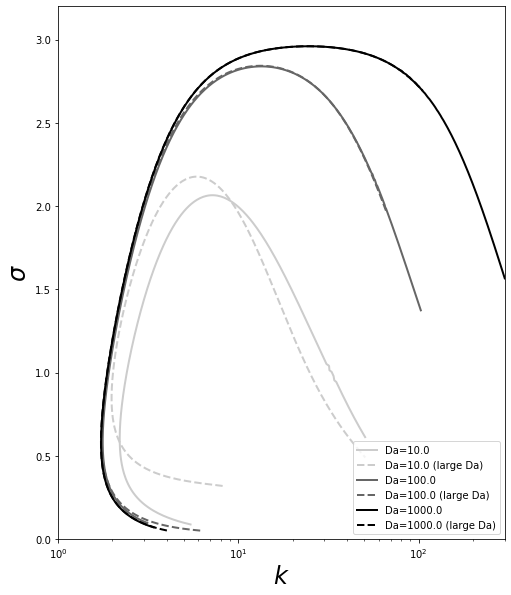

In [14]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(4.0 * zoom, 4.9 * zoom)
f.set_facecolor('w')

for vals, gray in zip([10., 100., 1000.], [0.8, 0.4, 0.0]):
    plt.plot(DC_cube[vals].k, DC_cube[vals].s, '-', linewidth=2, 
             color=[gray, gray, gray], label=r'Da='+str(vals))
    plt.plot(DC_quad[vals].k, DC_quad[vals].s, '--', linewidth=2, 
             color=[gray, gray, gray], label=r'Da=' + str(vals) + ' (large Da)')

plt.xscale('log')
plt.xlim(1, 300)
plt.xlabel(r'$k$', fontsize=24)
plt.ylim(0, 3.2)
plt.ylabel(r'$\sigma$', fontsize=24)
plt.legend()
plt.show()


### A modified problem and its analytical solution

In [15]:
class PAR:
    def __init__(self):
        self.s = None
        self.k = None
        self.smax = None
        self.kmax = None
        self.X = None
        self.Y = None
        self.P = None
        self.phi = None
        self.U = None
        self.W = None

        
def ReactiveFlowAnalyticalSolution(k, n, Da, Pe, S):
    K = (1 + k**2 / Da / Pe).astype(np.clongdouble)
    b = np.pi
    # growth rate - upper branch
    full = np.zeros((k.shape[0], 2), dtype=np.clongdouble)
    b2 = b ** 2
    Da2 = Da ** 2
    Da3 = Da ** 3
    Da4 = Da ** 4
    K2 = K ** 2
    K4 = K ** 4
    k2 = k ** 2
    k4 = k ** 4
    k6 = k ** 6
    S2 = S ** 2
    full[:, 0] = (2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4
                                    - 3.0 * Da3 * K2 * S * k4 - 2 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4)
                  + 4 * Da * K * b2 * n + Da * K * k2 * n + 2 * Da2 * K * S * k2 * n) / (
            4 * S * Da2 * K2 * b2 + 4 * S * Da2 * K2 * k2 + S * k4)
    # lower branch
    full[:, 1] = -(2.0 * n * np.sqrt(- Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4
                                     - 3 * Da3 * K2 * S * k4 - 2 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4)
                   - K * (4 * Da * n * b2 + n * (2 * S * Da2 + Da) * k2)) / (
            S * (4 * Da2 * K2 * b2 + 4 * Da2 * K2 * k2 + k4))

    real1 = np.nonzero(np.imag(full[:, 0]).astype(np.float32) == 0.0)
    real2 = np.nonzero(np.imag(full[:, 1]).astype(np.float32) == 0.0)
    s = PAR()
    s.s = np.real(np.concatenate((np.flipud(full[real1, 0].flatten()), full[real2, 1].flatten())))
    s.k = np.real(np.concatenate((np.flipud(k[real1].flatten()), k[real2].flatten())))
    I = np.argmax(s.s)
    s.smax = s.s[I]
    s.kmax = s.k[I]

    # eigenfunctions
    K = 1 + s.kmax ** 2 / Da / Pe
    a = 0.5 * (n * K / S + s.smax * s.kmax ** 2 / Da) / (s.smax * K - n / Da / S)
    m = a + 1j * np.pi
    lambda_ = 2 * np.pi / s.kmax
    x = np.linspace(0, 2 * lambda_, 1000)
    hx = x[2]-x[1]
    y = np.linspace(0, 1, 1000)
    hy = y[2]-y[1]
    s.X, s.Y = np.meshgrid(x, y)
    s.P = np.exp(a * s.Y) * np.sin(np.pi * s.Y) * np.sin(s.kmax * s.X)
    tmp = np.exp(a * s.Y) * np.cos(np.pi * s.Y) * np.sin(s.kmax * s.X)
    dphi_dy = S * ((a ** 2 - np.pi ** 2 - s.kmax ** 2) * s.P + 2 * a * np.pi * tmp) / n
    s.phi = np.cumsum(dphi_dy, axis=0) * hy

    Px, Py = np.gradient(s.P, hx, hy)
    s.U = -S * Px
    s.W = (n - 1) * s.phi - S * Py

    s.P = (s.P - np.amin(s.P)) / (np.amax(s.P) - np.amin(s.P))
    s.phi = (s.phi - np.amin(s.phi)) / (np.amax(s.phi) - np.amin(s.phi))
    
    return s

In [16]:
n = 3.
Da = 1000.
Pe = 100.
S = np.asarray([0.01, 0.1, 1, 10]).astype(np.clongdouble)
k = np.logspace(-1.0, 4.0, 10000).astype(np.clongdouble)
s = []

for s_ in S:
    s.append(ReactiveFlowAnalyticalSolution(k, n, Da, Pe, s_))

/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


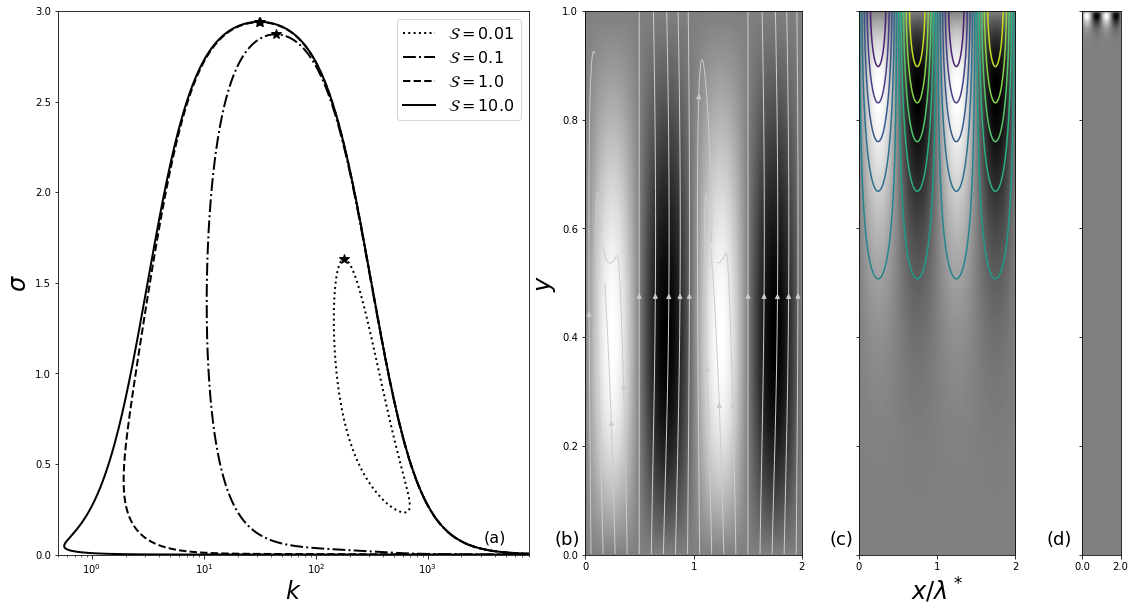

In [17]:
zoom = 2.0
fig = plt.figure(figsize=(zoom*9.7, zoom*5.0))
gs = gridspec.GridSpec(1, 4, width_ratios=[6, 3, 2, 1])

ax0 = plt.subplot(gs[0])
for s_, lstyi, S_ in zip(s, {'--k', '-k', '-.k', ':k'}, S):
    ax0.semilogx(s_.k, s_.s, lstyi, linewidth=2, 
                 label=r'$\mathcal{S}=' + str(np.real(S_).astype(np.float32)) + '$')
    ax0.plot(s_.kmax, s_.smax, '*k', linewidth=1, markersize=10)
ax0.set_xlabel(r'$k$', fontsize=24)
ax0.set_xlim(0.5, 8000)
ax0.set_xticks(ticks=(1.e0, 1.e1, 1.e2, 1.e3))
ax0.set_ylabel(r'$\sigma$', fontsize=24)
ax0.set_ylim(0.0, 3.0)
ax0.legend(fontsize=16)
ax0.text(0.5e4, 0.05, '(a)', fontsize=16, verticalalignment='bottom', horizontalalignment='right')

AR = 2 * np.pi / np.asarray([s[2].kmax, s[1].kmax, s[0].kmax])

ax1 = plt.subplot(gs[1])
lambda_ = np.float32(AR[0])
ax1 = plt.subplot(gs[1])
ax1.imshow(np.real(s[2].P).astype(np.float32), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
ax1.set_ylabel(r'$y$', fontsize=24)
nlines = 18
h = 2 * lambda_ / (nlines + 1)
seed = np.zeros((nlines, 2))
seed[:, 0] = np.linspace(0.5 * h, 2.0 * lambda_ - 0.5 * h, nlines)
seed[:, 1] = np.ones_like(seed[:, 0]) / 1000.0
epsilon = 3e-3
U = epsilon * np.real(s[2].U).astype(np.float64)
W = 1.0 + epsilon * np.real(s[2].W).astype(np.float64)
x = np.linspace(0, 2 * lambda_, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
ax1.streamplot(X, Y, U, W, start_points=seed,
               integration_direction='forward', color=[0.8, 0.8, 0.8], linewidth=1)
ax1.set_xticks((0, AR[0], 2*AR[0]))
ax1.set_xticklabels((0, 1, 2))
ax1.text(-0.01, 0.01, '(b)', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

ax2 = plt.subplot(gs[2])
lambda_ = np.float32(AR[1])
ax2 = plt.subplot(gs[2])
ax2.imshow(np.flipud(np.real(s[1].P)).astype(np.float32), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
x = np.linspace(0, 2 * lambda_, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
ax2.contour(X, Y, np.real(s[1].phi).astype(np.float32), levels=np.linspace(0, 1, 12))
ax2.set_xticks((0, lambda_, 2*lambda_))
ax2.set_xticklabels((0, 1, 2))
ax2.set_yticklabels(())
ax2.set_xlabel(r'$x/\lambda^*$', fontsize=24)
ax2.text(-0.01, 0.01, r'(c)', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

ax3 = plt.subplot(gs[3])
lambda_ = np.float32(AR[2])
ax3.imshow(np.flipud(np.real(s[0].P)).astype(np.float32), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
ax3.set_xticks((0, 2*lambda_))
ax3.set_xticklabels((0., 2.))
ax3.set_yticklabels(())
plt.text(-0.02, 0.01, r'(d)', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

plt.show()

#### test

In [2]:
class SA_Growth():
    def __init__(self):
        self.k = None
        self.a = None
        self.e = None
        self.s = None


class SA_Dispersion():
    def __init__(self):
        self.s = None
        self.k = None


def asym_maxgrowth(k, n, Da, Pe, S, l):
    b = l * np.pi
    B = b**2 + 1.0/4.0/S**2
    s_ = SA_Growth()
    k = np.power(4.0*Da*Pe*(b**2 + 1.0/4.0/S**2)/(4.0 + Pe/Da), 0.25)
    a = 1.0/2.0/S + k**2.0/2.0/Da
    e = (a**2 + b**2)/k**2 + k**2/Da/Pe
    s = n*(1.0 - 1.0/Da/2.0/S - 2.0*np.sqrt(B*(1.0/Da/Pe + 1.0/4.0/Da**2)))
    s_.k = np.real(k).astype(np.float32)
    s_.a = np.real(a).astype(np.float32)
    s_.e = np.real(e).astype(np.float32)
    s_.s = np.real(s).astype(np.float32)
    return s_


def asym_dispersion(k, n, Da, Pe, S, l):
    a = 1/2/S + k**2/2/Da
    b = l * np.pi
    epsilon = (a**2 + b**2)/k**2 + k**2/Da/Pe
    s = n*(1-epsilon)
    s[np.imag(s) != 0.0] = np.nan
    return np.real(s).astype(np.float32)


def full_dispersion(k, n, Da, Pe, S, l):
    b = np.clongdouble(l * np.pi)
    b2 = b ** 2
    k2 = k**2
    k4 = k2 * k2
    k6 = k2 * k4
    Da = np.clongdouble(Da)
    Da2 = Da ** 2
    Da3 = Da * Da2
    Da4 = Da2 * Da2
    K = 1.0 + k2 / Da / np.clongdouble(Pe)
    K2 = K ** 2
    K4 = K2 * K2
    S2 = np.clongdouble(S ** 2)

    # upper branch
    su = (2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4 - 3.0 * Da3 * K2 * S * k4
                            - 2.0 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4) + 4.0 * Da * K * b2 * n
          + Da * K * k2 * n + 2.0 * Da2 * K * S * k2 * n) / (4.0 * S * Da2 * K2 * b2 + 4.0 * S * Da2 * K2 * k2 + S * k4)
    iu = np.imag(su) == 0.0
    # lower branch
    sl = -(2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4 - 3.0 * Da3 * K2 * S * k4
                             - 2.0 * Da2 * K2 * b2 * k2 - Da*S*k6 - b2 * k4)
           - K*(4 * Da * n * b2 + n * (2.0 * S * Da2 + Da) * k2)) / (S*(4 * Da2 * K2 * b2 + 4.0 * Da2 * K2 * k2 + k4))
    il = np.imag(sl) == 0
    s = SA_Dispersion()
    s.s = np.hstack([np.flip(np.real(su[iu]).astype(np.float32)), np.real(sl[il]).astype(np.float32)])
    s.k = np.hstack([np.flip(np.real(k[iu]).astype(np.float32)), np.real(k[il]).astype(np.float32)])
    return s

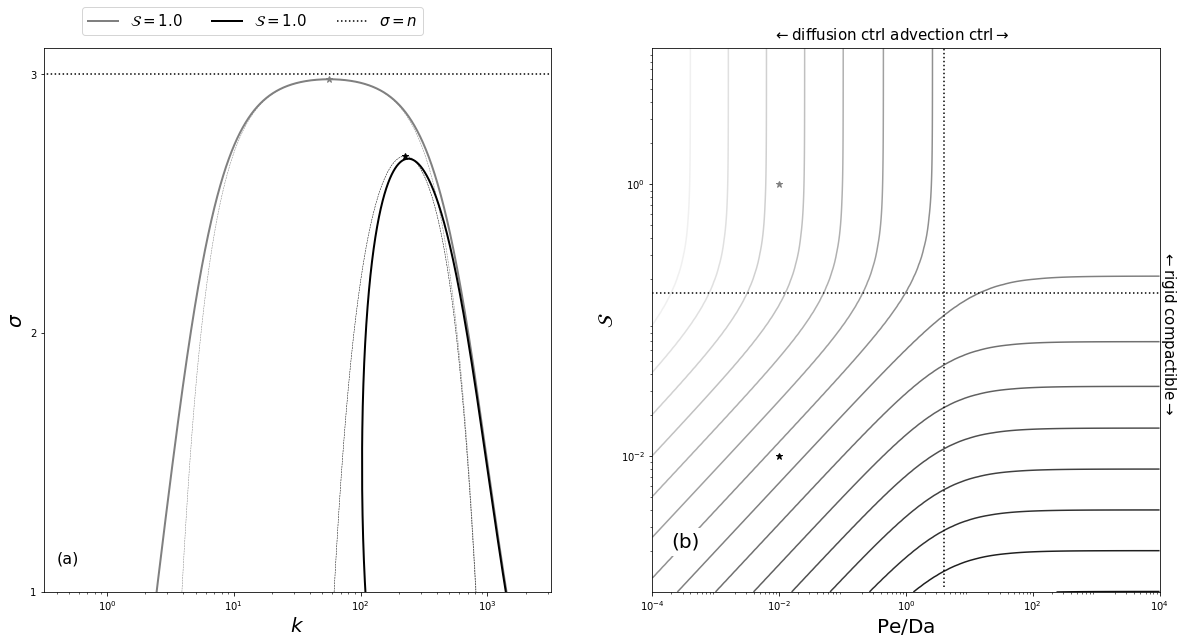

In [42]:
zoom = 2.0
fig = plt.figure(figsize=(10*zoom, 5*zoom))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax0 = plt.subplot(gs[0])

Da = 1e4
k = np.logspace(-1, 4, 10000).astype(np.clongdouble)
n = 3
Pe = Da / 100
S = np.asarray([1.0, 0.01]).astype(np.clongdouble)
l = 1.0

sfull = full_dispersion(k, n, Da, Pe, S[0], l)
sasym = asym_dispersion(k, n, Da, Pe, S[0], l)
smax = asym_maxgrowth(k, n, Da, Pe, S[0], l)
ax0.loglog(sfull.k, sfull.s, '-k', linewidth=2, color=[0.5, 0.5, 0.5],
           label=r'$\mathcal{S}='+str(np.real(S[0]))+'$')
ax0.loglog(k, sasym, '--k', linewidth=0.5, color=[0.5, 0.5, 0.5])
ax0.plot(smax.k, smax.s, '*k', markersize=7, color=[0.5, 0.5, 0.5])

sfull = full_dispersion(k, n, Da, Pe, S[1], l)
sasym = asym_dispersion(k, n, Da, Pe, S[1], l)
smax = asym_maxgrowth(k, n, Da, Pe, S[1], l)
ax0.loglog(sfull.k, sfull.s, '-k', linewidth=2, label=r'$\mathcal{S}='+str(np.real(S[0]))+'$')
ax0.loglog(k, sasym, '--k', linewidth=0.5)
ax0.plot(smax.k, smax.s, '*k', markersize=7)

ax0.plot([k[0], k[-1]], [n, n], ':k', label=r'$\sigma=n$')

ax0.set_xlim(np.sqrt(0.1), np.power(10, 3.5))
ax0.set_xticks([1.e0, 1.e1, 1.e2, 1.e3])
ax0.set_xlabel(r'$k$', fontsize=20)

ax0.set_ylabel(r'$\sigma$', fontsize=20)
ax0.set_ylim(1.0, 3.1)
ax0.set_yscale('linear')
ax0.set_yticks([1, 2, 3])

ax0.text(0.4, 1.1, r'(a)', fontsize=16, verticalalignment='bottom', horizontalalignment='left')

ax0.legend(fontsize=15, loc='upper left', bbox_to_anchor=(0.06, 1.09), ncol=3)

ax1 = plt.subplot(gs[1])

Spts = S
Pe_Da = Pe / Da

Pe = np.logspace(np.log10(Da) - 4.0, np.log10(Da) + 4, 100)
S = np.logspace(-3.0, 1.0, 100)
X, Y = np.meshgrid(Pe, S)
B = np.pi ** 2 + 1. / (2 * Y) ** 2
Ks = np.power(4 * Da * X * B / (4 + X / Da), 0.25)
lambda_ = 2 * np.pi / Ks

ax1.contour(Pe / Da, S, np.log10(lambda_), 16, cmap='gray')
ax1.plot([Pe[0]/Da, Pe[-1]/Da], [1/2/np.pi, 1/2/np.pi], ':k')
ax1.plot([4, 4], [S[1], S[-1]], ':k')
ax1.plot(Pe_Da, Spts[0], '*k', markersize=7, color=[0.5, 0.5, 0.5])
ax1.plot(Pe_Da, Spts[1], '*k', markersize=7)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks((1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4))
ax1.set_yticks((1.e-2, 1.e0))
ax1.set_ylabel(r'$\mathcal{S}$', fontsize=20)
ax1.set_xlabel(r'Pe$/$Da', fontsize=20)
ax1.text(0.0002, 0.002, r'(b)', fontsize=20, verticalalignment='bottom',
         horizontalalignment='left', backgroundcolor='w')
ax1.text(1.4e4, 0.02, r'$\leftarrow$rigid compactible$\rightarrow$', rotation=-90, horizontalalignment='center',
         verticalalignment='bottom', fontsize=15)
ax1.text(0.58, 11, r'$\leftarrow$diffusion ctrl advection ctrl$\rightarrow$', horizontalalignment='center',
         verticalalignment='bottom', fontsize=15)

plt.show()

## Application to the mantle

In [43]:
class PAR:
    def __init__(self):
        self.n = 3  # permeability exponent
        self.S = 3e-5  # rigidity parameter
        self.Da = 7e7  # Damkohler number
        self.Pe = 7e9  # Peclet number
        self.H = 8e4  # column height, metres
        self.tscale = 1 * 0.01 / 3e-11 / 2e-6 / (np.pi * 1e7)  # years


def Dispersion(k, n, Da, Pe, S):
    k = k.astype(np.clongdouble)
    k2 = k * k
    k4 = k2 * k2
    k6 = k4 * k2
    n, Da, Pe, S = np.clongdouble([n, Da, Pe, S])
    K = 1 + k ** 2 / Da / Pe
    K2 = K * K
    K4 = K2 * K2
    Da2 = Da * Da
    Da3 = Da2 * Da
    Da4 = Da2 * Da2
    b = np.clongdouble(np.pi)
    b2 = b * b
    S2 = S * S
    # upper branch
    s = (2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4 - 3.0 * Da3 * K2 * S * k4
                           - 2 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4) + 4.0 * Da * K * b2 * n + Da * K * k2 * n
         + 2 * Da2 * K * S * k2 * n) / (4 * S * Da2 * K2 * b2 + 4.0 * S * Da2 * K2 * k2 + S * k4)
    s[np.imag(s) != 0.0] = np.nan
    return np.real(s).astype(np.float32)

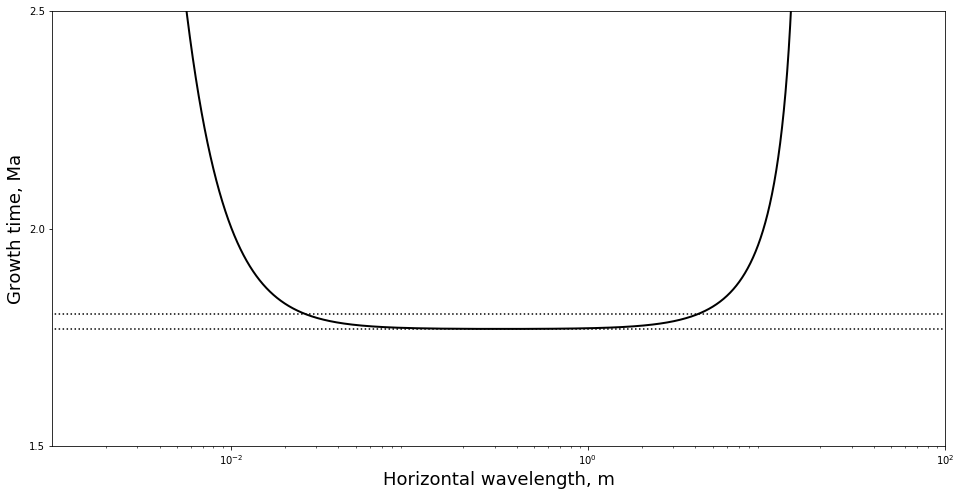

In [47]:
zoom = 2.0
fig = plt.figure(figsize=(8*zoom, 4*zoom))

par = PAR()
k = np.logspace(4, 8, 10000)
s = Dispersion(k, par.n, par.Da, par.Pe, par.S)

lambda_ = (2 * np.pi / k) * par.H  # metres
tau = (1. / s) * par.tscale / 1e6  # million years
tau_ref = (1. / par.n) * par.tscale / 1e6  # million years
tau_ref90 = (1.02 / par.n) * par.tscale / 1e6  # million years

plt.semilogx(lambda_, tau, '-k', linewidth=2)
plt.plot([1e-5, 1e5], [tau_ref, tau_ref], ':k')
plt.plot([1e-5, 1e5], [tau_ref90, tau_ref90], ':k')
plt.xlim(1e-3, 1e2)
plt.ylim(1.5, 2.5)
plt.xticks((1e-2, 1e0, 1e2))
plt.yticks((1.5, 2.0, 2.5))
plt.xlabel('Horizontal wavelength, m', fontsize=18)
plt.ylabel('Growth time, Ma', fontsize=18)

plt.show()